<a href="https://colab.research.google.com/github/jaayg23/PLN/blob/main/2.%20Transformer/Transformer_Parte_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo UNAL CHEC](https://www.funcionpublica.gov.co/documents/d/guest/logo-universidad-nacional)



# **Transformer Parte 1**
### Departamento de Ingeniería Eléctrica, Electrónica y Computación
#### Universidad Nacional de Colombia - Sede Manizales

#### Profesor: Diego A. Pérez

# De Self-Attention (1 cabeza) a **Multi-Head Self-Attention**

## ¿Por qué varias “cabezas”?
En self-attention de **una sola cabeza**, aprendemos **una** proyección de consultas (Q), claves (K) y valores (V).  
En **Multi-Head**, en lugar de una sola, aprendemos **h** proyecciones *diferentes* y ejecutamos **h atenciones en paralelo**. Cada cabeza puede “mirar” **patrones distintos** (por ejemplo, relaciones de corto vs. largo alcance, o distintas funciones gramaticales).

## Idea general
1. Partimos de una representación por token $X \in \mathbb{R}^{B\times T\times d_{\text{model}}}$.
2. Proyectamos a Q, K, V **compartidos** $(B,T,d_{\text{model}})$ y luego **repartimos** en $h$ cabezas:  
   - $Q \rightarrow (B, h, T, d_k)$  
   - $K \rightarrow (B, h, T, d_k)$  
   - $V \rightarrow (B, h, T, d_v)$  
   (típicamente $d_k=d_v=\frac{d_{\text{model}}}{h}$)
3. Para **cada cabeza**:  
   $$
   \text{Scores}_h = \frac{Q_h K_h^\top}{\sqrt{d_k}} \quad\Rightarrow\quad A_h = \text{softmax}(\text{Scores}_h)
   $$
   $$
   O_h = A_h V_h
   $$
4. **Concatenamos** las salidas de todas las cabezas $(B,T,h\cdot d_v)$ y aplicamos una proyección final $W^O$ para volver a $(B,T,d_{\text{model}})$.

## Máscara
- La **máscara de padding** debe **broadcast** a $(B, h, 1, T)$ para anular posiciones *key* de padding en **todas las cabezas**.

A continuación, reemplazamos la sección de “una cabeza” por **multi-head** (con `num_heads = 4`).


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import pandas as pd

# ===== Reutilizamos tu preprocesamiento previo (carga, tokenización, padding, class_weights) =====
# 1) Carga de datos
url = "https://raw.githubusercontent.com/juacardonahe/Curso_NLP/refs/heads/main/data/SMSSpamCollection/SMSSpamCollection"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# 2) Longitud (percentil 95) y split
df['message_length'] = df['message'].apply(lambda x: len(str(x).split()))
max_length = 128
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df['message'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# 3) Tokenizer y secuencias
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='pre', truncating='pre')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_length, padding='pre', truncating='pre')

# 4) Class weights
from sklearn.utils.class_weight import compute_class_weight
cw = compute_class_weight(class_weight='balanced', classes=np.array([0,1]), y=y_train.values)
class_weights = {0: float(cw[0]), 1: float(cw[1])}

# ===== Modelo con Multi-Head Self-Attention =====
tf.keras.backend.clear_session()

# Dimensiones
embed_dim = 128
d_model   = 128         # dimensión del "modelo" (salida por token antes/después de atención)
num_heads = 4
head_dim  = d_model // num_heads   # d_k = d_v = 32

assert d_model % num_heads == 0, "d_model debe ser múltiplo de num_heads"

inputs = layers.Input(shape=(max_length,), dtype="int32", name="tokens")

# --- Máscara (1=token válido, 0=pad) ---
mask_bool = layers.Lambda(lambda x: tf.cast(tf.not_equal(x, 0), tf.float32), name="mask_bool")(inputs)  # (B,T)
# Para atención: (B, 1, 1, T) para "key" mask; se broadcast a (B,h,T,T) vía broadcasting
key_mask  = layers.Lambda(lambda m: tf.reshape(m, (-1, 1, 1, tf.shape(m)[-1])), name="key_mask")(mask_bool)
# Para pooling temporal después: (B,T,1)
time_mask = layers.Lambda(lambda m: tf.expand_dims(m, axis=-1), name="time_mask")(mask_bool)

# --- Embedding y proyección previa (igual que antes) ---
emb = layers.Embedding(vocab_size, embed_dim, mask_zero=False, name="E")(inputs)
x   = layers.Dense(d_model, activation="relu", name="f_mlp")(emb)  # (B,T,d_model)

# --- Proyecciones "compartidas" a Q,K,V (luego dividimos en cabezas) ---
WQ = layers.Dense(d_model, use_bias=False, name="WQ")(x)  # (B,T,d_model)
WK = layers.Dense(d_model, use_bias=False, name="WK")(x)  # (B,T,d_model)
WV = layers.Dense(d_model, use_bias=False, name="WV")(x)  # (B,T,d_model)

def split_heads(t):
    # t: (B,T,d_model) -> (B, h, T, head_dim)
    B = tf.shape(t)[0]
    T = tf.shape(t)[1]
    t = tf.reshape(t, (B, T, num_heads, head_dim))
    return tf.transpose(t, perm=(0, 2, 1, 3))

Qh = layers.Lambda(split_heads, name="split_Q")(WQ)  # (B,h,T,head_dim)
Kh = layers.Lambda(split_heads, name="split_K")(WK)  # (B,h,T,head_dim)
Vh = layers.Lambda(split_heads, name="split_V")(WV)  # (B,h,T,head_dim)

# --- Scaled dot-product attention por cabeza ---
def scaled_dot_product_attention(q, k, v, key_mask):
    """
    q,k,v: (B,h,T,head_dim)
    key_mask: (B,1,1,T) con 1 en tokens válidos, 0 en pads (broadcast a cada cabeza)
    """
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scores = tf.matmul(q, k, transpose_b=True) / tf.sqrt(dk)   # (B,h,T,T)

    # aplicar máscara sobre los ejes de "key": …, …, …, T
    # donde key_mask = 0 -> -1e9
    scores = scores + (1. - key_mask) * (-1e9)

    attn = tf.nn.softmax(scores, axis=-1)  # (B,h,T,T)
    out  = tf.matmul(attn, v)              # (B,h,T,head_dim)
    return out, attn

Oh, Attn = layers.Lambda(lambda args: scaled_dot_product_attention(*args),
                         name="SDPA")([Qh, Kh, Vh, key_mask])
# Oh: (B,h,T,head_dim)

# --- Concatenar cabezas y proyección de salida ---
def combine_heads(t):
    # (B,h,T,head_dim) -> (B,T,h*head_dim=d_model)
    t = tf.transpose(t, perm=(0, 2, 1, 3))            # (B,T,h,head_dim)
    B = tf.shape(t)[0]; T = tf.shape(t)[1]
    return tf.reshape(t, (B, T, num_heads*head_dim))  # (B,T,d_model)

O_concat = layers.Lambda(combine_heads, name="concat_heads")(Oh)  # (B,T,d_model)

# Proyección Wo (opcional pero estándar)
O_proj = layers.Dense(d_model, use_bias=False, name="Wo")(O_concat)  # (B,T,d_model)

# --- Pooling temporal enmascarado (promedio sobre tokens válidos) ---
sum_O     = layers.Lambda(lambda om: tf.reduce_sum(om[0] * om[1], axis=1),
                          name="sum_O")([O_proj, time_mask])     # (B,d_model)
len_valid = layers.Lambda(lambda m: tf.reduce_sum(m, axis=1) + 1e-9,
                          name="len_valid")(time_mask)           # (B,1)
pooled    = layers.Lambda(lambda sl: sl[0] / sl[1], name="pooled")([sum_O, len_valid])  # (B,d_model)

# Clasificador
logits = layers.Dense(1, activation="sigmoid", name="cls")(pooled)

model_mh = Model(inputs, logits, name="MultiHead_SelfAttn_SMS")
model_mh.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model_mh.summary()


Model: "MultiHead_SelfAttn_SMS"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tokens (InputLayer) │ (None, 128)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ E (Embedding)       │ (None, 128, 128)  │  1,015,680 │ tokens[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ f_mlp (Dense)       │ (None, 128, 128)  │     16,512 │ E[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ WQ (Dense)          │ (None, 128, 128)  │     16,384 │ f_mlp[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ WK (Dense)          │ (None, 128, 128)  │     16,384 │ f_mlp[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ WV (Dense)          │ (None, 128, 128)  │     16,384 │ f_mlp[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_bool (Lambda)  │ (None, 128)       │          0 │ tokens[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ split_Q (Lambda)    │ (None, 4, 128,    │          0 │ WQ[0][0]          │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ split_K (Lambda)    │ (None, 4, 128,    │          0 │ WK[0][0]          │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ split_V (Lambda)    │ (None, 4, 128,    │          0 │ WV[0][0]          │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ key_mask (Lambda)   │ (None, 1, 1, 128) │          0 │ mask_bool[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SDPA (Lambda)       │ [(None, 4, 128,   │          0 │ split_Q[0][0],    │
│                     │ 32), (None, 4,    │            │ split_K[0][0],    │
│                     │ 128, 128)]        │            │ split_V[0][0],    │
│                     │                   │            │ key_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_heads        │ (None, 128, 128)  │          0 │ SDPA[0][0]        │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Wo (Dense)          │ (None, 128, 128)  │     16,384 │ concat_heads[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_mask (Lambda)  │ (None, 128, 1)    │          0 │ mask_bool[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sum_O (Lambda)      │ (None, 128)       │          0 │ Wo[0][0],         │
│                     │                   │            │ time_mask[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ len_valid (Lambda)  │ (None, 1)         │          0 │ time_mask[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled (Lambda)     │ (None, 128)       │          0 │ sum_O[0][0],      │
│                     │                   │            │ len_valid[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls (Dense)         │ (None, 1)         │        129 │ pooled[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,097,857 (4.19 MB)

 Trainable params: 1,097,857 (4.19 MB)

 Non-trainable params: 0 (0.00 B)

## Puntos clave del código
- **`num_heads = 4`** y **`head_dim = d_model / num_heads`** ⇒ cada cabeza opera en un subespacio más pequeño.  
- **Máscara**: `key_mask` de forma $(B,1,1,T)$ se suma a `scores (B,h,T,T)` gracias a *broadcasting*.  
- **`split_heads`** y **`combine_heads`** organizan tensores a $(B,h,T,d)$ y de vuelta a $(B,T,d_{\text{model}})$.  
- **`Wo`** remezcla la información concatenada de las $h$ cabezas en el espacio de $d_{\text{model}}$.

> Si quieres una versión “caja negra”, Keras tiene `layers.MultiHeadAttention`, pero aquí lo implementamos “a mano” para reforzar el entendimiento de shapes y máscaras.

---

## ¿Por qué **multi-head** ayuda?
- Cada cabeza puede **atender relaciones distintas** en paralelo (p. ej., dependencias cortas vs. largas).  
- La concatenación y proyección final **mezcla** esas perspectivas en una representación más rica.  
- En práctica, esto suele **mejorar** la capacidad del modelo de capturar patrones complejos del lenguaje.




In [2]:
history = model_mh.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=3,
    batch_size=64,
    class_weight=class_weights,
    verbose=1
)

loss, acc = model_mh.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test accuracy (Multi-Head): {acc:.4f}")


Epoch 1/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8747 - loss: 0.5095 - val_accuracy: 0.9439 - val_loss: 0.1650
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9824 - loss: 0.0577 - val_accuracy: 0.9552 - val_loss: 0.1148
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9947 - loss: 0.0147 - val_accuracy: 0.9798 - val_loss: 0.0706
Test accuracy (Multi-Head): 0.9830


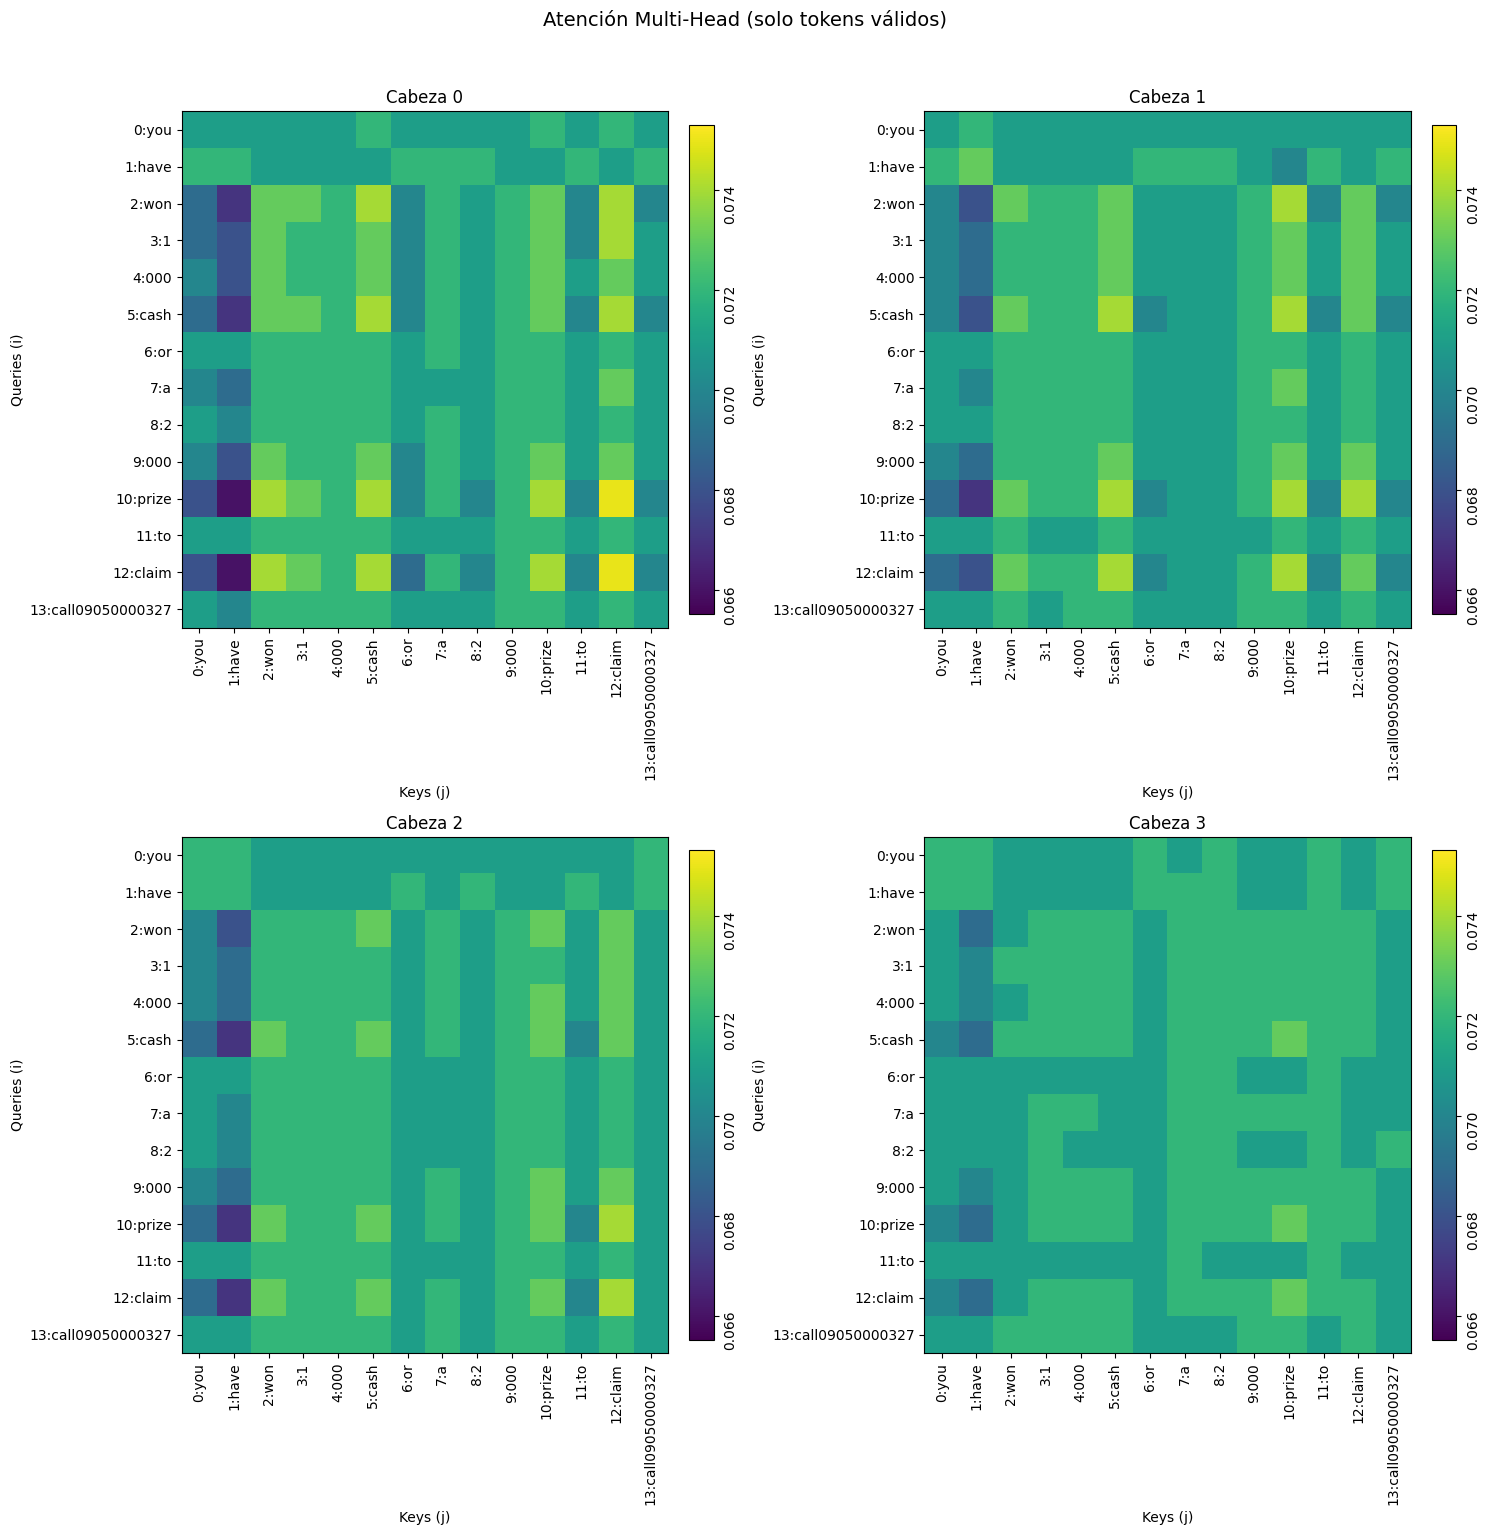

Cabeza 0 - Suma por fila (≈1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Cabeza 1 - Suma por fila (≈1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Cabeza 2 - Suma por fila (≈1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Cabeza 3 - Suma por fila (≈1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
import matplotlib.pyplot as plt

def show_multihead_attention(sample_index, valid_only=True, decimals=3, share_colorbar=True):
    """
    Dibuja las matrices de atención (A) de TODAS las cabezas.
    - valid_only=True: recorta <pad> y muestra solo tokens válidos.
    - decimals: redondeo para visualizar mejor.
    - share_colorbar=True: una sola barra de color compartida; si False, una por subplot.
    """
    # 1) Construimos un modelo auxiliar que expone el tensor de atención (B,h,T,T)
    att_out = model_mh.get_layer("SDPA").output
    # La Lambda "SDPA" devuelve (Oh, Attn); tomamos el segundo
    if isinstance(att_out, (list, tuple)) and len(att_out) == 2:
        A_tensor = att_out[1]
    else:
        A_tensor = att_out  # fallback (por si se cambió la Lambda)
    A_model = Model(model_mh.input, A_tensor)

    # 2) Texto -> ids con padding
    text = X_test.iloc[sample_index]
    seq = tokenizer.texts_to_sequences([text])
    pad = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_length, padding='pre', truncating='pre')
    ids = pad[0]

    # 3) Ejecutar el modelo de atención
    A_pred = A_model.predict(pad, verbose=0)   # (1, h, T, T)
    A_full = A_pred[0]                         # (h, T, T)
    num_heads = A_full.shape[0]
    T = A_full.shape[1]

    # 4) Construir etiquetas y recorte opcional a tokens válidos
    index_word = tokenizer.index_word
    if valid_only:
        valid_idx = np.where(ids != 0)[0]
        if valid_idx.size == 0:
            print("No hay tokens válidos en esta secuencia.")
            return
        tokens = [index_word.get(int(ids[i]), "<unk>") for i in valid_idx]
        labels = [f"{k}:{tok}" for k, tok in enumerate(tokens)]
        # Recortar A por ambas dimensiones (queries y keys)
        A_list = [A_full[h][np.ix_(valid_idx, valid_idx)] for h in range(num_heads)]
    else:
        tokens = [index_word.get(int(t), "<unk>") if t!=0 else "<pad>" for t in ids]
        labels = [f"{i}:{tok}" for i, tok in enumerate(tokens)]
        A_list = [A_full[h] for h in range(num_heads)]

    # 5) Grid de subplots (2x2 si h=4; ajusta para otros casos)
    n_cols = int(np.ceil(np.sqrt(num_heads)))
    n_rows = int(np.ceil(num_heads / n_cols))

    # Definir rango común de color para comparar cabezas
    vmin = min(a.min() for a in A_list)
    vmax = max(a.max() for a in A_list)

    # Tamaños de figura escalados por longitud
    L = len(labels)
    fig_w = max(6, L * 0.45)
    fig_h = max(5, n_rows * max(4, L * 0.4))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    if not isinstance(axes, np.ndarray):
        axes = np.array([[axes]])
    axes = axes.flatten()

    ims = []
    for h in range(num_heads):
        ax = axes[h]
        A = np.round(A_list[h], decimals)
        im = ax.imshow(A, aspect='auto', vmin=vmin, vmax=vmax)
        ims.append(im)
        ax.set_title(f"Cabeza {h}")
        ax.set_xticks(range(L))
        ax.set_xticklabels(labels, rotation=90, ha='center')
        ax.set_yticks(range(L))
        ax.set_yticklabels(labels)
        ax.set_xlabel("Keys (j)")
        ax.set_ylabel("Queries (i)")

    # Ocultar ejes sobrantes si el grid es mayor que h
    for k in range(num_heads, len(axes)):
        axes[k].axis('off')

    # Colorbar
    if share_colorbar:
        # una barra de color compartida
        cbar = fig.colorbar(ims[0], ax=axes[:num_heads], fraction=0.02, pad=0.02)
        cbar.ax.tick_params(labelrotation=90)
    else:
        # una barra por subplot
        for im, ax in zip(ims, axes[:num_heads]):
            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelrotation=90)

    title = "Atención Multi-Head (solo tokens válidos)" if valid_only else "Atención Multi-Head (incluye <pad>)"
    fig.suptitle(title, y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

    # 6) (Opcional) verificar que cada fila de cada cabeza suma ≈ 1
    for h in range(num_heads):
        rs = A_list[h].sum(axis=1)
        print(f"Cabeza {h} - Suma por fila (≈1):", np.round(rs, 3))

# Ejemplo de uso:
# Muestra las 4 cabezas con la misma escala de color y sin <pad>
show_multihead_attention(sample_index=3, valid_only=True, decimals=3, share_colorbar=False)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model
from IPython.display import display

# =========================
# Utilidades multi-head
# =========================

def _pad_text(text, tokenizer, max_length):
    seq = tokenizer.texts_to_sequences([text])
    return tf.keras.preprocessing.sequence.pad_sequences(
        seq, maxlen=max_length, padding='pre', truncating='pre'
    )

def _attn_model_from_layer(model_mh, attn_layer_name="SDPA"):
    """
    Construye un modelo auxiliar que expone el tensor de atención (B,h,T,T)
    desde la Lambda 'SDPA' que devuelve (Oh, Attn).
    """
    att_out = model_mh.get_layer(attn_layer_name).output
    A_tensor = att_out[1] if isinstance(att_out, (list, tuple)) else att_out
    return Model(model_mh.input, A_tensor)

def _valid_tokens_and_A_heads(pad, tokenizer, A_model):
    """
    Devuelve:
      - tokens válidos (sin <pad>)
      - A_heads recortada a tokens válidos con forma (h, T_valid, T_valid)
    """
    ids = pad[0]
    valid_idx = np.where(ids != 0)[0]
    index_word = tokenizer.index_word
    tokens = [index_word.get(int(ids[i]), "<unk>") for i in valid_idx]

    A_pred = A_model.predict(pad, verbose=0)   # (1, h, T, T)
    A_full = A_pred[0]                         # (h, T, T)

    if valid_idx.size == 0:
        return [], np.zeros((A_full.shape[0], 0, 0))

    # recorta por consultas (filas) y claves (columnas)
    A_heads = np.stack([A_full[h][np.ix_(valid_idx, valid_idx)] for h in range(A_full.shape[0])], axis=0)
    return tokens, A_heads  # (h, Tv, Tv)


# =========================
# 1) Barras por consulta (fila i) — por cabeza o promedio
# =========================

def bar_scores_for_query_mh(
    sample_index, X_test, tokenizer, max_length, model_mh,
    query='last', head='avg', sort=False, decimals=3, attn_layer_name="SDPA"
):
    """
    Visualiza los pesos de atención de UNA consulta específica:
      - query='last' -> usa el último token válido
      - query=int    -> índice de token válido (0..T_valid-1)
    'head' puede ser:
      - 'avg'  -> promedia todas las cabezas (mantiene suma de la fila ≈ 1)
      - int    -> muestra una cabeza específica (0..h-1)
    """
    A_model = _attn_model_from_layer(model_mh, attn_layer_name)
    text = X_test.iloc[sample_index]
    pad = _pad_text(text, tokenizer, max_length)
    tokens, A_heads = _valid_tokens_and_A_heads(pad, tokenizer, A_model)

    Tv = len(tokens)
    if Tv == 0:
        print("No hay tokens válidos."); return

    # escoger consulta
    i = Tv - 1 if query == 'last' else int(query)
    if not (0 <= i < Tv):
        raise ValueError(f"query debe estar en [0, {Tv-1}] o ser 'last'.")

    # seleccionar cabeza(s)
    h = A_heads.shape[0]
    if head == 'avg':
        w = A_heads.mean(axis=0)[i]   # promedio de cabezas, fila i  -> (Tv,)
        head_title = "Promedio de cabezas"
    else:
        if not (0 <= head < h):
            raise ValueError(f"head debe estar en [0, {h-1}] o ser 'avg'.")
        w = A_heads[head][i]          # una cabeza, fila i
        head_title = f"Cabeza {head}"

    labels = [f"{j}:{tok}" for j, tok in enumerate(tokens)]
    if sort:
        order = np.argsort(-w)
        w = w[order]; labels = [labels[j] for j in order]

    print(f"[muestra {sample_index}] Consulta {i}:{tokens[i]} | {head_title} | suma fila ≈ {w.sum():.3f}")
    plt.figure(figsize=(max(6, len(labels)*0.5), 3.8))
    plt.bar(range(len(labels)), w)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.ylabel("Peso de atención (fila i)")
    plt.title(f"Atención de la consulta {i}:{tokens[i]} — {head_title}")
    plt.tight_layout()
    plt.show()

    df = pd.DataFrame({"token": labels, "peso": np.round(w, decimals)})
    display(df)


# =========================
# 2) Importancia promedio por clave (columna) — por cabeza o promedio
# =========================

def bar_scores_per_key_mean_mh(
    sample_index, X_test, tokenizer, max_length, model_mh,
    head='avg', sort=False, decimals=3, attn_layer_name="SDPA"
):
    """
    Importancia por clave: promedio por columna de A (promedio sobre las consultas/fila).
    'head':
      - 'avg' -> promedio de cabezas (promedia matrices A a lo largo del eje de h)
      - int   -> una cabeza específica
    """
    A_model = _attn_model_from_layer(model_mh, attn_layer_name)
    text = X_test.iloc[sample_index]
    pad = _pad_text(text, tokenizer, max_length)
    tokens, A_heads = _valid_tokens_and_A_heads(pad, tokenizer, A_model)

    Tv = len(tokens)
    if Tv == 0:
        print("No hay tokens válidos."); return

    h = A_heads.shape[0]
    if head == 'avg':
        A_use = A_heads.mean(axis=0)   # (Tv, Tv) promedio de cabezas
        head_title = "Promedio de cabezas"
    else:
        if not (0 <= head < h):
            raise ValueError(f"head debe estar en [0, {h-1}] o ser 'avg'.")
        A_use = A_heads[head]
        head_title = f"Cabeza {head}"

    w = A_use.mean(axis=0)  # promedio a través de las filas (consultas) -> importancia como clave
    labels = [f"{j}:{tok}" for j, tok in enumerate(tokens)]
    if sort:
        order = np.argsort(-w)
        w = w[order]; labels = [labels[j] for j in order]

    print(f"[muestra {sample_index}] Importancia promedio (columna) — {head_title}")
    plt.figure(figsize=(max(6, len(labels)*0.5), 3.8))
    plt.bar(range(len(labels)), w)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.ylabel("Atención promedio recibida")
    plt.title(f"Importancia promedio por token (clave) — {head_title}")
    plt.tight_layout()
    plt.show()

    #df = pd.DataFrame({"token": labels, "peso_promedio": np.round(w, decimals)})
    #display(df)


# =========================
# 3) Relevancia GLOBAL por token (agregando 4 cabezas + TODAS las consultas)
# =========================

def bar_global_relevance_mh(
    sample_index, X_test, tokenizer, max_length, model_mh,
    agg='mean', sort=True, decimals=3, attn_layer_name="SDPA"
):
    """
    Relevancia GLOBAL por token como clave, agregando:
      - sobre todas las CABEZAS (h)
      - sobre todas las CONSULTAS (filas i)

    agg:
      - 'mean': promedio sobre (h, i) -> w_j = mean_{h,i} A[h,i,j]
      - 'sum' : suma (útil si quieres que el total sea >1 y refleje longitud)

    Nota: este vector NO tiene por qué sumar 1 (no es una fila de A, es un agregado).
    """
    A_model = _attn_model_from_layer(model_mh, attn_layer_name)
    text = X_test.iloc[sample_index]
    pad = _pad_text(text, tokenizer, max_length)
    tokens, A_heads = _valid_tokens_and_A_heads(pad, tokenizer, A_model)

    Tv = len(tokens)
    if Tv == 0:
        print("No hay tokens válidos."); return

    if agg == 'mean':
        w = A_heads.mean(axis=(0,1))  # (Tv,)
        title = "Relevancia GLOBAL (promedio sobre cabezas y consultas)"
    elif agg == 'sum':
        w = A_heads.sum(axis=(0,1))   # (Tv,)
        title = "Relevancia GLOBAL (suma sobre cabezas y consultas)"
    else:
        raise ValueError("agg debe ser 'mean' o 'sum'.")

    labels = [f"{j}:{tok}" for j, tok in enumerate(tokens)]
    if sort:
        order = np.argsort(-w)
        w = w[order]; labels = [labels[j] for j in order]

    print(f"[muestra {sample_index}] {title}")
    plt.figure(figsize=(max(6, len(labels)*0.5), 3.8))
    plt.bar(range(len(labels)), w)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.ylabel("Importancia agregada")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    df = pd.DataFrame({"token": labels, "importancia": np.round(w, decimals)})
    #display(df)



# 3) Importancia promedio por token (columna) promediando las 4 cabezas

# 4) Relevancia GLOBAL agregando sobre cabezas y consultas (promedio)



[muestra 1] Consulta 0:ok | Cabeza 0 | suma fila ≈ 1.000


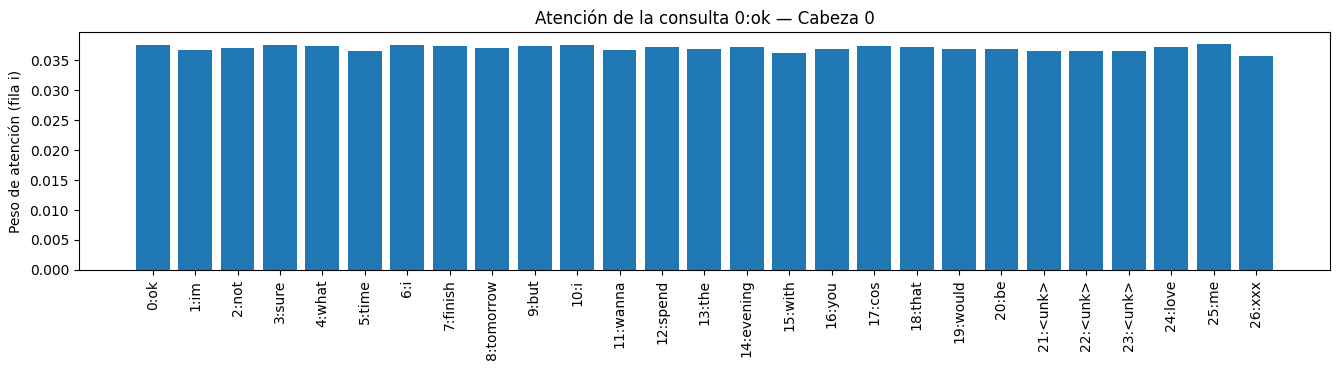

,token,peso
0,0:ok,0.038
1,1:im,0.037
2,2:not,0.037
3,3:sure,0.037
4,4:what,0.037
5,5:time,0.037
6,6:i,0.038
7,7:finish,0.037
8,8:tomorrow,0.037
9,9:but,0.037


In [5]:
bar_scores_for_query_mh(sample_index=1, X_test=X_test, tokenizer=tokenizer, max_length=max_length, model_mh=model_mh,
                        query=0, head=0, sort=False)


[muestra 1] Relevancia GLOBAL (promedio sobre cabezas y consultas)


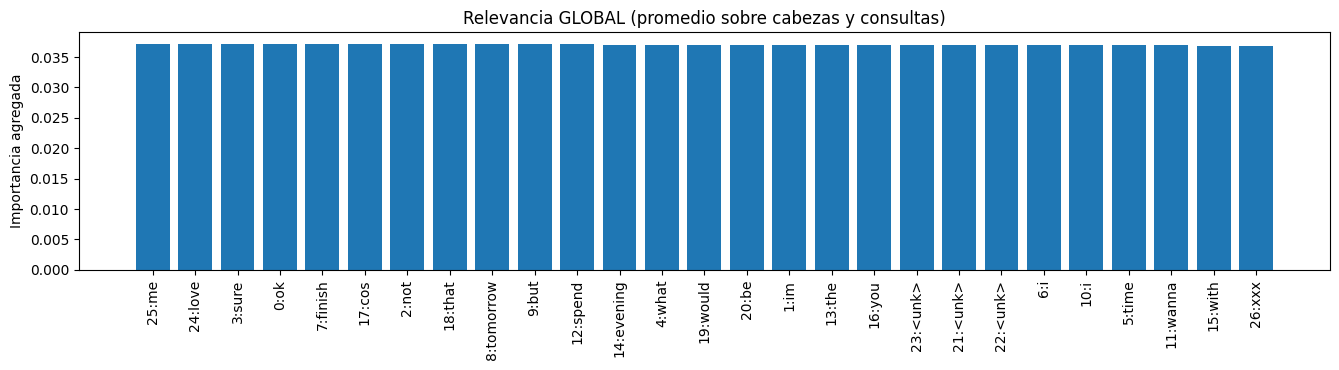

In [6]:
bar_global_relevance_mh(sample_index=1, X_test=X_test, tokenizer=tokenizer, max_length=max_length, model_mh=model_mh,
                        agg='mean', sort=True)

#Bloque Transformer: LayerNorm y Feed-Forward (FFN)

Hasta ahora construimos **Self-Attention** y **Multi-Head Self-Attention**.  
Para completar un **bloque Transformer** necesitamos:

1) **Residual connections (Add):** suman la **entrada** de una subcapa con su **salida** → mejor flujo de gradientes y estabilidad.
2) **Layer Normalization (LayerNorm):** normaliza cada token **a lo largo de la dimensión de características** → estabiliza activaciones.
3) **Feed-Forward Network (FFN):** MLP **por token** (misma red para todas las posiciones) que remezcla información no linealmente.

## Estructura (Post-LN clásico)
Dado un tensor por tokens $X \in \mathbb{R}^{B \times T \times d_{\text{model}}}$:

1. **Multi-Head Attention**: $ \mathrm{MHA}(X) \in \mathbb{R}^{B \times T \times d_{\text{model}}} $  
2. **Add & LayerNorm**:  
   $$
   X^{(1)} = \mathrm{LayerNorm}\big(X + \mathrm{Dropout}(\mathrm{MHA}(X))\big)
   $$
3. **Feed-Forward (dos capas densas)**:  
   $$
   \mathrm{FFN}(X) = \mathrm{Dropout}\big(W_2\, \phi(W_1 X + b_1) + b_2\big)
   $$  
   con \(\phi\) = ReLU o GELU.
4. **Add & LayerNorm**:  
   $$
   X^{(2)} = \mathrm{LayerNorm}\big(X^{(1)} + \mathrm{FFN}(X^{(1)})\big)
   $$

> **Nota:** El **LayerNorm** en Transformers se aplica por token (eje de características), **no** sobre el batch.

## ¿Por qué esto ayuda?
- **Add (residual):** facilita el aprendizaje de “correcciones” en lugar de funciones completas.
- **LayerNorm:** estabiliza activaciones (importante con atención y redes profundas).
- **FFN:** añade capacidad no lineal por token; piensa en él como “refinar” cada representación tras mezclar contexto con atención.


In [7]:
# ======================
# Setup: dataset + tokenización (igual que antes)
# ======================
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# 1) Carga
url = "https://raw.githubusercontent.com/juacardonahe/Curso_NLP/refs/heads/main/data/SMSSpamCollection/SMSSpamCollection"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# 2) Longitud (p95) y split
df['message_length'] = df['message'].apply(lambda x: len(str(x).split()))
max_length = int(df['message_length'].quantile(0.95))

X_train, X_test, y_train, y_test = train_test_split(
    df['message'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# 3) Tokenizer y padding
tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length, padding='pre', truncating='pre')
X_test_pad  = pad_sequences(tokenizer.texts_to_sequences(X_test),  maxlen=max_length, padding='pre', truncating='pre')

# 4) Class weights
cw = compute_class_weight(class_weight='balanced', classes=np.array([0,1]), y=y_train.values)
class_weights = {0: float(cw[0]), 1: float(cw[1])}
class_weights


{0: 0.577481212749417, 1: 3.7265886287625416}

## Construimos el **bloque Transformer** (Attention → Add&Norm → FFN → Add&Norm)

- Usamos **Multi-Head Self-Attention** “a mano” (como antes) para mantener el control de máscaras y formas.
- Añadimos:
  - **Dropout** en la salida de atención y en la FFN.
  - **Residual + LayerNorm** tras cada subcapa.
  - Una **FFN** con `d_ff = 4 * d_model` (regla común).


In [8]:
from tensorflow.keras import layers, Model

tf.keras.backend.clear_session()

# Dimensiones
d_model   = 128
num_heads = 4
head_dim  = d_model // num_heads  # 32
d_ff      = 4 * d_model           # 512
drop_rate = 0.1
embed_dim = 128

# ---- Inputs y máscara ----
inputs = layers.Input(shape=(max_length,), dtype="int32", name="tokens")
mask_bool = layers.Lambda(lambda x: tf.cast(tf.not_equal(x, 0), tf.float32), name="mask_bool")(inputs)  # (B,T)
key_mask  = layers.Lambda(lambda m: tf.reshape(m, (-1, 1, 1, tf.shape(m)[-1])), name="key_mask")(mask_bool)  # (B,1,1,T)

# ---- Embedding + proyección a d_model ----
emb = layers.Embedding(vocab_size, embed_dim, mask_zero=False, name="E")(inputs)
x0  = layers.Dense(d_model, activation="relu", name="proj_to_dmodel")(emb)  # (B,T,d_model)

# ---- Multi-Head Self-Attention (manual, como antes) ----
WQ = layers.Dense(d_model, use_bias=False, name="WQ")(x0)
WK = layers.Dense(d_model, use_bias=False, name="WK")(x0)
WV = layers.Dense(d_model, use_bias=False, name="WV")(x0)

def split_heads(t):
    # (B,T,d_model) -> (B,h,T,head_dim)
    B = tf.shape(t)[0]; T = tf.shape(t)[1]
    t = tf.reshape(t, (B, T, num_heads, head_dim))
    return tf.transpose(t, (0,2,1,3))

Qh = layers.Lambda(split_heads, name="split_Q")(WQ)
Kh = layers.Lambda(split_heads, name="split_K")(WK)
Vh = layers.Lambda(split_heads, name="split_V")(WV)

def scaled_dot_product_attention(q, k, v, key_mask):
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scores = tf.matmul(q, k, transpose_b=True) / tf.sqrt(dk)  # (B,h,T,T)
    scores = scores + (1. - key_mask) * (-1e9)                # mask keys
    attn   = tf.nn.softmax(scores, axis=-1)                   # (B,h,T,T)
    out    = tf.matmul(attn, v)                               # (B,h,T,head_dim)
    return out, attn

Oh, Attn = layers.Lambda(lambda args: scaled_dot_product_attention(*args), name="SDPA")([Qh, Kh, Vh, key_mask])

def combine_heads(t):
    # (B,h,T,head_dim) -> (B,T,d_model)
    t = tf.transpose(t, (0,2,1,3))
    B = tf.shape(t)[0]; T = tf.shape(t)[1]
    return tf.reshape(t, (B, T, num_heads*head_dim))

O_concat = layers.Lambda(combine_heads, name="concat_heads")(Oh)
O_proj   = layers.Dense(d_model, use_bias=False, name="Wo")(O_concat)  # (B,T,d_model)
O_drop   = layers.Dropout(drop_rate, name="attn_dropout")(O_proj)

# ---- Residual + LayerNorm (After Attention) ----
attn_out = layers.Add(name="resid_attn")([x0, O_drop])                  # (B,T,d_model)
attn_ln  = layers.LayerNormalization(epsilon=1e-6, name="attn_layernorm")(attn_out)

# ---- Feed-Forward por token ----
ffn_in   = attn_ln
ffn_hid  = layers.Dense(d_ff, activation="relu", name="ffn_dense1")(ffn_in)
ffn_drop = layers.Dropout(drop_rate, name="ffn_dropout")(ffn_hid)
ffn_out  = layers.Dense(d_model, name="ffn_dense2")(ffn_drop)

# ---- Residual + LayerNorm (After FFN) ----
ffn_res  = layers.Add(name="resid_ffn")([attn_ln, ffn_out])              # (B,T,d_model)
x_block  = layers.LayerNormalization(epsilon=1e-6, name="ffn_layernorm")(ffn_res)

# ---- Pooling temporal (promedio sobre tokens válidos) ----
time_mask = layers.Lambda(lambda m: tf.expand_dims(m, -1), name="time_mask")(mask_bool)  # (B,T,1)
sum_X     = layers.Lambda(lambda xm: tf.reduce_sum(xm[0] * xm[1], axis=1), name="sum_tokens")([x_block, time_mask])
len_valid = layers.Lambda(lambda m: tf.reduce_sum(m, axis=1) + 1e-9, name="len_valid")(time_mask)
pooled    = layers.Lambda(lambda sl: sl[0]/sl[1], name="mean_pool")( [sum_X, len_valid] )

# ---- Clasificador ----
logits = layers.Dense(1, activation="sigmoid", name="cls")(pooled)

model_block = Model(inputs, logits, name="TransformerBlock_SMS")
model_block.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model_block.summary(line_length=120)


Model: "TransformerBlock_SMS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ tokens (InputLayer)               │ (None, 33)                   │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ E (Embedding)                     │ (None, 33, 128)              │         1,015,680 │ tokens[0][0]              
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ proj_to_dmodel (Dense)            │ (None, 33, 128)              │            16,512 │ E[0][0]                   
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ WQ (Dense)                        │ (None, 33, 128)              │            16,384 │ proj_to_dmodel[0][0]      
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ WK (Dense)                        │ (None, 33, 128)              │            16,384 │ proj_to_dmodel[0][0]      
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ WV (Dense)                        │ (None, 33, 128)              │            16,384 │ proj_to_dmodel[0][0]      
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ mask_bool (Lambda)                │ (None, 33)                   │                 0 │ tokens[0][0]              
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ split_Q (Lambda)                  │ (None, 4, 33, 32)            │                 0 │ WQ[0][0]                  
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ split_K (Lambda)                  │ (None, 4, 33, 32)            │                 0 │ WK[0][0]                  
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ split_V (Lambda)                  │ (None, 4, 33, 32)            │                 0 │ WV[0][0]                  
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ key_mask (Lambda)                 │ (None, 1, 1, 33)             │                 0 │ mask_bool[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ SDPA (Lambda)                     │ [(None, 4, 33, 32), (None,   │                 0 │ split_Q[0][0], split_K[0][
│                                   │ 4, 33, 33)]                  │                   │ split_V[0][0], key_mask[0]
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ concat_heads (Lambda)             │ (None, 33, 128)              │                 0 │ SDPA[0][0]                
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ Wo (Dense)                        │ (None, 33, 128)              │            16,384 │ concat_heads[0][0]        
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ attn_dropout (Dropout)            │ (None, 33, 128)              │                 0 │ Wo[0][0]                  
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ resid_attn (Add)                  │ (None, 33, 128)   

 Total params: 1,230,081 (4.69 MB)

 Trainable params: 1,230,081 (4.69 MB)

 Non-trainable params: 0 (0.00 B)

##  Entrenamiento corto (demo)

Entrenamos unas pocas épocas para ver que el **forward-pass** y la **optimización** funcionan.  
*(En clase, puedes aumentar `epochs`, usar `EarlyStopping` y regularización).*


In [9]:
history = model_block.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=2,
    batch_size=64,
    class_weight=class_weights,
    verbose=1
)

loss, acc = model_block.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test accuracy (Transformer Block): {acc:.4f}")


Epoch 1/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 183ms/step - accuracy: 0.7845 - loss: 0.4178 - val_accuracy: 0.9709 - val_loss: 0.0843
Epoch 2/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9907 - loss: 0.0290 - val_accuracy: 0.9798 - val_loss: 0.0703
Test accuracy (Transformer Block): 0.9839


## (Opcional) ¿Qué hace **LayerNorm** por token?

LayerNorm normaliza **cada token** a lo largo de sus **d_model** características:
- media ≈ 0, var ≈ 1 (antes de gamma/beta).  
- estabiliza la escala de activaciones, útil con atenciones y redes profundas.

A continuación mostramos, para un batch pequeño, la **media** y **desviación** por token **antes** y **después** de `attn_layernorm`.


In [10]:
# Extraemos tensores intermedios: x0 (antes de atención) y attn_ln (después de Add&LayerNorm de atención)
probe_model = Model(
    model_block.input,
    outputs=[
        model_block.get_layer("proj_to_dmodel").output,  # x0
        model_block.get_layer("attn_layernorm").output   # después de Add&Norm (attn)
    ]
)

sample_inp = X_test_pad[:8]
x_before, x_after = probe_model.predict(sample_inp, verbose=0)  # (B,T,d_model) cada uno

# Calculamos mean y std por token (eje=-1)
mb = np.mean(x_before, axis=-1)
sb = np.std (x_before, axis=-1)
ma = np.mean(x_after,  axis=-1)
sa = np.std (x_after,  axis=-1)

print("Antes LayerNorm — media por token (primer ejemplo):\n", np.round(mb[0], 3))
print("Antes LayerNorm — std   por token (primer ejemplo):\n", np.round(sb[0], 3))
print("\nDespués LayerNorm — media por token (primer ejemplo):\n", np.round(ma[0], 3))
print("Después LayerNorm — std   por token (primer ejemplo):\n", np.round(sa[0], 3))


Antes LayerNorm — media por token (primer ejemplo):
 [0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011
 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.013 0.008
 0.01  0.009 0.009 0.011 0.017 0.013 0.013 0.012 0.012]
Antes LayerNorm — std   por token (primer ejemplo):
 [0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017
 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.017 0.02  0.014
 0.016 0.016 0.019 0.021 0.028 0.027 0.022 0.019 0.019]

Después LayerNorm — media por token (primer ejemplo):
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.001  0.001 -0.     0.001  0.    -0.     0.001  0.001
  0.001  0.001  0.001]
Después LayerNorm — std   por token (primer ejemplo):
 [0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997
 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 1.002 0.999
 0.

## Resumen

- **Add & LayerNorm** tras atención y tras FFN estabilizan y aceleran el entrenamiento.  
- **FFN** aporta no linealidad y capacidad por token (misma red aplicada a cada posición).  
- Juntos, **Attention → Add&Norm → FFN → Add&Norm** forman el **bloque básico** de los Transformers.



In [11]:
import numpy as np

np.random.seed(0)

# ---------------------------
# Configuración del ejemplo
# ---------------------------
T = 3               # tokens en la secuencia
d_model = 6         # dimensión del modelo
num_heads = 3       # -> head_dim = 2
head_dim = d_model // num_heads
assert d_model % num_heads == 0

d_ff = 12           # ancho interno de la FFN
eps = 1e-5          # para LayerNorm

# ---------------------------
# Datos de entrada (T, d_model)
# ---------------------------
X = np.random.randn(T, d_model)   # una sola secuencia (sin batch)
print("X (entrada) shape:", X.shape)

# ---------------------------
# Funciones auxiliares
# ---------------------------
def layernorm(x, gamma, beta, eps=1e-5):
    """
    LayerNorm por token: normaliza sobre la última dimensión (d_model)
    x: (T, d_model)
    gamma, beta: (d_model,)
    """
    mu = x.mean(axis=-1, keepdims=True)
    var = x.var(axis=-1, keepdims=True)
    x_hat = (x - mu) / np.sqrt(var + eps)
    return gamma * x_hat + beta, mu.squeeze(-1), var.squeeze(-1)

def gelu(x):
    return 0.5 * x * (1.0 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * (x**3))))

def split_heads(t, num_heads, head_dim):
    """
    t: (T, d_model) -> (num_heads, T, head_dim)
    """
    return t.reshape(T, num_heads, head_dim).transpose(1,0,2)

def combine_heads(t):
    """
    t: (num_heads, T, head_dim) -> (T, num_heads*head_dim=d_model)
    """
    return t.transpose(1,0,2).reshape(T, -1)

def softmax_last_dim(x):
    x = x - x.max(axis=-1, keepdims=True)
    e = np.exp(x)
    return e / (e.sum(axis=-1, keepdims=True) + 1e-12)

# ---------------------------
# Parámetros "aprendibles"
# ---------------------------

# LayerNorm 1 (antes de MHA) - Pre-LN
gamma1 = np.ones(d_model)
beta1  = np.zeros(d_model)

# Proyecciones Q, K, V
W_Q = np.random.randn(d_model, d_model) * 0.3
W_K = np.random.randn(d_model, d_model) * 0.3
W_V = np.random.randn(d_model, d_model) * 0.3

# Proyección de salida de MHA
W_O = np.random.randn(d_model, d_model) * 0.3

# LayerNorm 2 (antes de FFN) - Pre-LN
gamma2 = np.ones(d_model)
beta2  = np.zeros(d_model)

# FFN
W1 = np.random.randn(d_model, d_ff) * 0.3
b1 = np.zeros(d_ff)
W2 = np.random.randn(d_ff, d_model) * 0.3
b2 = np.zeros(d_model)

# ---------------------------
# Bloque Transformer (Pre-LN)
# ---------------------------

# === Subcapa 1: Multi-Head Self-Attention ===
# Pre-LN
X_norm1, mu1, var1 = layernorm(X, gamma1, beta1, eps)
# Q,K,V
Q = X_norm1 @ W_Q    # (T, d_model)
K = X_norm1 @ W_K    # (T, d_model)
V = X_norm1 @ W_V    # (T, d_model)

# separa en cabezas
Qh = split_heads(Q, num_heads, head_dim)   # (h, T, head_dim)
Kh = split_heads(K, num_heads, head_dim)   # (h, T, head_dim)
Vh = split_heads(V, num_heads, head_dim)   # (h, T, head_dim)

# atención por cabeza
scores = np.einsum('hik,hjk->hij', Qh, Kh) / np.sqrt(head_dim)  # (h, T, T)
A = softmax_last_dim(scores)                                     # (h, T, T)
Oh = np.einsum('hij,hjk->hik', A, Vh)                            # (h, T, head_dim)

# une cabezas y proyecta
O = combine_heads(Oh)                # (T, d_model)
O_proj = O @ W_O                     # (T, d_model)

# Residual
X_attn = X + O_proj                  # (T, d_model)

# === Subcapa 2: FFN ===
# Pre-LN
X_norm2, mu2, var2 = layernorm(X_attn, gamma2, beta2, eps)

H = gelu(X_norm2 @ W1 + b1)         # (T, d_ff)
Y = H @ W2 + b2                     # (T, d_model)

# Residual
X_out = X_attn + Y                   # (T, d_model)

# ---------------------------
# Impresiones pedagógicas
# ---------------------------
print("\n--- Formas ---")
print("Q, K, V:", Q.shape, K.shape, V.shape)
print("Qh, Kh, Vh:", Qh.shape, Kh.shape, Vh.shape, "(h, T, head_dim)")
print("scores (h,T,T):", scores.shape)
print("A (attn)       :", A.shape)
print("Oh (h,T,d)     :", Oh.shape)
print("O (T,d_model)  :", O.shape)
print("O_proj         :", O_proj.shape)
print("X_attn (resid) :", X_attn.shape)
print("H (T,d_ff)     :", H.shape)
print("Y (T,d_model)  :", Y.shape)
print("X_out final    :", X_out.shape)

print("\n--- LayerNorm stats (token 0) ---")
print("LN1 mean,var (token 0):", round(mu1[0],3), round(var1[0],3))
print("LN2 mean,var (token 0):", round(mu2[0],3), round(var2[0],3))

print("\n--- Atenciones por cabeza (redondeadas) ---")
for h in range(num_heads):
    print(f"Cabeza {h} - A[h]:\n", np.round(A[h], 3))

print("\nX_out (primeras filas, redondeado):\n", np.round(X_out, 3))


X (entrada) shape: (3, 6)

--- Formas ---
Q, K, V: (3, 6) (3, 6) (3, 6)
Qh, Kh, Vh: (3, 3, 2) (3, 3, 2) (3, 3, 2) (h, T, head_dim)
scores (h,T,T): (3, 3, 3)
A (attn)       : (3, 3, 3)
Oh (h,T,d)     : (3, 3, 2)
O (T,d_model)  : (3, 6)
O_proj         : (3, 6)
X_attn (resid) : (3, 6)
H (T,d_ff)     : (3, 12)
Y (T,d_model)  : (3, 6)
X_out final    : (3, 6)

--- LayerNorm stats (token 0) ---
LN1 mean,var (token 0): 1.046 1.189
LN2 mean,var (token 0): 1.05 0.842

--- Atenciones por cabeza (redondeadas) ---
Cabeza 0 - A[h]:
 [[0.067 0.823 0.11 ]
 [0.457 0.051 0.492]
 [0.164 0.429 0.407]]
Cabeza 1 - A[h]:
 [[0.371 0.27  0.359]
 [0.312 0.1   0.588]
 [0.373 0.259 0.369]]
Cabeza 2 - A[h]:
 [[0.303 0.425 0.272]
 [0.455 0.081 0.463]
 [0.175 0.678 0.147]]

X_out (primeras filas, redondeado):
 [[ 1.626  0.774  1.847  1.142  1.819  0.266]
 [ 0.677 -0.477 -1.124  0.261  0.753  2.169]
 [ 0.884  0.721 -0.033  0.224  2.034  1.014]]


# Encoder Transformer con MHA + LayerNorm + FFN (y atención visible)

- Construimos un mini-encoder con **3 bloques** (cada bloque: `MHA → Add&Norm → FFN → Add&Norm`).
- **Máscara de padding** para que `<pad>` no reciba ni emita atención.
- Entrenamos en **SMS Spam** y medimos **accuracy** y **AUC**.
- Visualizamos las **matrices de atención**:
  - por **capa** (1, 2 o 3),
  - por **cabeza** o promedio de cabezas,
  - y una **relevancia global** por token (agrega cabezas y consultas).

**¿Qué atención mirar si tengo varias capas?**  
- Por defecto, se suele **mirar la última capa** (representaciones más “altas”).  
- A veces es interesante comparar **primera vs. última** para ver el cambio de patrones.


In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# 1) Carga de datos
url = "https://raw.githubusercontent.com/juacardonahe/Curso_NLP/refs/heads/main/data/SMSSpamCollection/SMSSpamCollection"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# 2) Split
max_length = 128
X_train, X_test, y_train, y_test = train_test_split(
    df['message'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# 3) Tokenizer y padding
tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length, padding='pre', truncating='pre')
X_test_pad  = pad_sequences(tokenizer.texts_to_sequences(X_test),  maxlen=max_length, padding='pre', truncating='pre')

print("Vocab size:", vocab_size)
print("Train shape:", X_train_pad.shape, "| Test shape:", X_test_pad.shape)


Vocab size: 7935
Train shape: (4457, 128) | Test shape: (1115, 128)


In [13]:
# ===============================
# Positional Encoding seno-coseno
# ===============================
from tensorflow.keras import layers, Model

def sinusoidal_pe(max_len, d_model):
    pos = tf.range(max_len, dtype=tf.float32)[:, None]
    i   = tf.range(d_model, dtype=tf.float32)[None, :]
    angle_rates = 1.0 / tf.pow(10000.0, (2*(i//2))/tf.cast(d_model, tf.float32))
    angles = pos * angle_rates
    s = tf.sin(angles[:, 0::2]); c = tf.cos(angles[:, 1::2])
    pe = tf.concat([s, c], axis=-1)
    return pe[None, ...]  # (1,T,D)

class AddSinusoidalPE(layers.Layer):
    def __init__(self, max_len, d_model, **kwargs):
        super().__init__(**kwargs)
        self.pe = sinusoidal_pe(max_len, d_model)
    def call(self, x):
        # x: (B,T,D)
        return x + self.pe[:, :tf.shape(x)[1], :]


In [14]:
# ===============================
# Bloque Transformer (Pre-LN) con máscara (B,T,T)
# ===============================
def transformer_block(x, attn_mask_bool, num_heads=4, d_model=128, d_ff=512, drop=0.1, name_prefix="blk"):
    # --- Pre-LN + MHA ---
    h = layers.LayerNormalization(epsilon=1e-6, name=f"{name_prefix}_ln1")(x)

    # attn_mask_bool: (B,T)  -> (B,T,T)  (query_mask AND key_mask)
    attn_mask_full = layers.Lambda(
        lambda m: tf.cast(
            tf.logical_and(tf.expand_dims(m, 2), tf.expand_dims(m, 1)),
            tf.float32
        ),
        output_shape=lambda s: (s[0], s[1], s[1]),
        name=f"{name_prefix}_attn_mask_full"
    )(attn_mask_bool)  # (B,T,T)

    mha = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=d_model//num_heads,
        dropout=drop,
        name=f"{name_prefix}_mha"
    )
    attn_out = mha(h, h, attention_mask=attn_mask_full)  # (B,T,D)
    h = layers.Dropout(drop, name=f"{name_prefix}_attn_drop")(attn_out)
    x = layers.Add(name=f"{name_prefix}_attn_resid")([x, h])

    # --- Pre-LN + FFN (position-wise) ---
    h = layers.LayerNormalization(epsilon=1e-6, name=f"{name_prefix}_ln2")(x)
    h = layers.Dense(d_ff, activation=tf.nn.gelu, name=f"{name_prefix}_ff1")(h)
    h = layers.Dropout(drop, name=f"{name_prefix}_ff_drop")(h)
    h = layers.Dense(d_model, name=f"{name_prefix}_ff2")(h)
    h = layers.Dropout(drop, name=f"{name_prefix}_ff_drop2")(h)
    x = layers.Add(name=f"{name_prefix}_ff_resid")([x, h])

    return x


In [15]:
# ===============================
# Modelo completo: 3 bloques + pooling + cls
# ===============================
tf.keras.backend.clear_session()

d_model   = 128
num_heads = 4
d_ff      = 512
drop      = 0.1

ids = layers.Input(shape=(max_length,), dtype="int32", name="ids")

# Máscara booleana (B,T) dentro de Lambda (evita error KerasTensor)
mask_bool = layers.Lambda(lambda t: tf.not_equal(t, 0), name="mask_bool")(ids)

# Embedding + PE
emb = layers.Embedding(vocab_size, d_model, mask_zero=False, name="emb")(ids)
x   = AddSinusoidalPE(max_len=max_length, d_model=d_model, name="add_pe")(emb)

# 3 bloques Transformer
for i in range(1, 4):
    x = transformer_block(
        x, attn_mask_bool=mask_bool,
        num_heads=num_heads, d_model=d_model, d_ff=d_ff, drop=drop,
        name_prefix=f"blk{i}"
    )

# LN final
x = layers.LayerNormalization(epsilon=1e-6, name="final_ln")(x)

# Mean pooling enmascarado
mask_f = layers.Lambda(lambda m: tf.cast(tf.expand_dims(m, -1), tf.float32), name="mask_float")(mask_bool)  # (B,T,1)
sum_x  = layers.Lambda(lambda xm: tf.reduce_sum(xm[0]*xm[1], axis=1), name="sum_tokens")([x, mask_f])      # (B,D)
len_x  = layers.Lambda(lambda m: tf.reduce_sum(m, axis=1) + 1e-9, name="len_tokens")(mask_f)               # (B,1)
pooled = layers.Lambda(lambda sl: sl[0]/sl[1], name="mean_pool")([sum_x, len_x])

# Clasificador
logits = layers.Dense(1, activation="sigmoid", name="cls")(pooled)

model = Model(ids, logits, name="SMS_Transformer_trainable")
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary(line_length=120)


Model: "SMS_Transformer_trainable"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ ids (InputLayer)                  │ (None, 128)                  │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ emb (Embedding)                   │ (None, 128, 128)             │         1,015,680 │ ids[0][0]                 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ add_pe (AddSinusoidalPE)          │ (None, 128, 128)             │                 0 │ emb[0][0]                 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ mask_bool (Lambda)                │ (None, 128)                  │                 0 │ ids[0][0]                 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ blk1_ln1 (LayerNormalization)     │ (None, 128, 128)             │               256 │ add_pe[0][0]              
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ blk1_attn_mask_full (Lambda)      │ (None, 128, 128)             │                 0 │ mask_bool[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ blk1_mha (MultiHeadAttention)     │ (None, 128, 128)             │            66,048 │ blk1_ln1[0][0],           
│                                   │                              │                   │ blk1_ln1[0][0],           
│                                   │                              │                   │ blk1_attn_mask_full[0][0] 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ blk1_attn_drop (Dropout)          │ (None, 128, 128)             │                 0 │ blk1_mha[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ blk1_attn_resid (Add)             │ (None, 128, 128)             │                 0 │ add_pe[0][0],             
│                                   │                              │                   │ blk1_attn_drop[0][0]      
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ blk1_ln2 (LayerNormalization)     │ (None, 128, 128)             │               256 │ blk1_attn_resid[0][0]     
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ blk1_ff1 (Dense)                  │ (None, 128, 512)             │            66,048 │ blk1_ln2[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ blk1_ff_drop (Dropout)            │ (None, 128, 512)             │                 0 │ blk1_ff1[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ blk1_ff2 (Dense)                  │ (None, 128, 128)             │            65,664 │ blk1_ff_drop[0][0]        
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ blk1_ff_drop2 (Dropout)           │ (None, 128, 128)             │                 0 │ blk1_ff2[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ blk1_ff_resid (Add)               │ (None, 128, 128)  

 Total params: 1,610,881 (6.15 MB)

 Trainable params: 1,610,881 (6.15 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# ===============================
# Entrenamiento y evaluación
# ===============================
hist = model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=3,
    batch_size=64,
    verbose=1
)

probs = model.predict(X_test_pad, batch_size=256, verbose=0).ravel()
preds = (probs >= 0.5).astype(int)

acc = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, probs)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test AUC:      {auc:.4f}")


Epoch 1/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 351ms/step - accuracy: 0.8592 - loss: 0.3523 - val_accuracy: 0.8901 - val_loss: 0.3086
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9382 - loss: 0.1856 - val_accuracy: 0.9664 - val_loss: 0.1147
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9852 - loss: 0.0502 - val_accuracy: 0.9865 - val_loss: 0.0522


Test Accuracy: 0.9812
Test AUC:      0.9914


In [17]:
# ====== Extractores de atención por capa (robustos) ======
from tensorflow.keras import layers, Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from IPython.display import display

extractors = {}

for i in [1, 2, 3]:
    # Entrada del extractor
    ids_in = layers.Input(shape=(max_length,), dtype="int32", name=f"ids_in_{i}")
    # Máscara booleana (B,T)
    mask_b = layers.Lambda(lambda t: tf.not_equal(t, 0), name=f"ex_mask_bool_{i}")(ids_in)
    # Máscara completa (B,T,T) (query AND key)
    mask_full = layers.Lambda(
        lambda m: tf.cast(
            tf.logical_and(tf.expand_dims(m, 2), tf.expand_dims(m, 1)),
            tf.float32
        ),
        output_shape=lambda s: (s[0], s[1], s[1]),
        name=f"ex_attn_mask_full_{i}"
    )(mask_b)

    # Reusar capas (mismos PESOS) del modelo principal:
    # embedding y PE
    emb_i = model.get_layer("emb")(ids_in)
    x_i   = model.get_layer("add_pe")(emb_i)

    # pasar por bloques 1..i-1 tal cual (sin scores)
    for j in range(1, i):
        ln1 = model.get_layer(f"blk{j}_ln1")(x_i)
        mha = model.get_layer(f"blk{j}_mha")
        attn_out = mha(ln1, ln1, attention_mask=mask_full)  # call normal
        h = model.get_layer(f"blk{j}_attn_drop")(attn_out)
        x_i = model.get_layer(f"blk{j}_attn_resid")([x_i, h])

        ln2 = model.get_layer(f"blk{j}_ln2")(x_i)
        h   = model.get_layer(f"blk{j}_ff1")(ln2)
        h   = model.get_layer(f"blk{j}_ff_drop")(h)
        h   = model.get_layer(f"blk{j}_ff2")(h)
        h   = model.get_layer(f"blk{j}_ff_drop2")(h)
        x_i = model.get_layer(f"blk{j}_ff_resid")([x_i, h])

    # capa i: LN1 y MHA con return_attention_scores=True en el CALL
    ln1_i = model.get_layer(f"blk{i}_ln1")(x_i)
    mha_i = model.get_layer(f"blk{i}_mha")
    _, scores_i = mha_i(
        ln1_i, ln1_i,
        attention_mask=mask_full,
        return_attention_scores=True
    )  # (B, heads, T, T)

    extractors[i] = Model(ids_in, scores_i, name=f"attn_extractor_blk{i}")

# ====== Helpers de visualización ======
index_word = tokenizer.index_word

def _pad_one(text: str):
    seq = tokenizer.texts_to_sequences([text])
    return pad_sequences(seq, maxlen=max_length, padding='pre', truncating='pre')

def show_attention(sample_index=0, layer_idx=3, head='avg', valid_only=True, decimals=3):
    text = X_test.iloc[sample_index]
    pad = _pad_one(text)
    ids_arr = pad[0]

    A_full = extractors[layer_idx].predict(pad, verbose=0)[0]  # (heads, T, T)

    valid_idx = np.where(ids_arr != 0)[0]
    if valid_only and valid_idx.size > 0:
        tokens = [index_word.get(int(ids_arr[i]), "<unk>") for i in valid_idx]
        A = A_full[:, valid_idx, :][:, :, valid_idx]           # (h, Tv, Tv)
    else:
        tokens = [index_word.get(int(t), "<unk>") if t!=0 else "<pad>" for t in ids_arr]
        A = A_full

    if head == 'avg':
        M = A.mean(axis=0)
        title = f"Capa {layer_idx} — Promedio de cabezas"
    else:
        M = A[head]
        title = f"Capa {layer_idx} — Cabeza {head}"

    L = len(tokens)
    fig, ax = plt.subplots(figsize=(max(6, L*0.5), max(5, L*0.5)))
    im = ax.imshow(np.round(M, decimals), aspect='auto')
    cbar = plt.colorbar(im, ax=ax); cbar.ax.tick_params(labelrotation=90)
    ax.set_xticks(range(L)); ax.set_yticks(range(L))
    ax.set_xticklabels([f"{i}:{t}" for i,t in enumerate(tokens)], rotation=90)
    ax.set_yticklabels([f"{i}:{t}" for i,t in enumerate(tokens)])
    ax.set_xlabel("Keys (j)"); ax.set_ylabel("Queries (i)")
    ax.set_title(title)
    plt.tight_layout(); plt.show()
    print("Suma por fila (≈1):", np.round(M.sum(axis=1), 3))

def bar_scores_for_query(sample_index=0, layer_idx=3, head='avg', query='last', sort=False, decimals=3):
    text = X_test.iloc[sample_index]
    pad = _pad_one(text)
    ids_arr = pad[0]

    A_full = extractors[layer_idx].predict(pad, verbose=0)[0]  # (h,T,T)
    valid_idx = np.where(ids_arr != 0)[0]
    if valid_idx.size == 0:
        print("No hay tokens válidos."); return

    tokens = [index_word.get(int(ids_arr[i]), "<unk>") for i in valid_idx]
    A = A_full[:, valid_idx, :][:, :, valid_idx]               # (h, Tv, Tv)
    Tv = len(tokens)

    M = A.mean(axis=0) if head == 'avg' else A[head]
    i = Tv - 1 if query == 'last' else int(query)
    w = M[i]
    labels = [f"{j}:{tok}" for j, tok in enumerate(tokens)]
    if sort:
        order = np.argsort(-w); w = w[order]; labels = [labels[j] for j in order]

    print(f"[muestra {sample_index}] Capa {layer_idx} | Consulta {i}:{tokens[i]} | suma fila ≈ {w.sum():.3f}")
    plt.figure(figsize=(max(6, len(labels)*0.5), 3.5))
    plt.bar(range(len(labels)), w)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.ylabel("Peso de atención (fila i)")
    plt.title(f"Atención de la consulta {i}:{tokens[i]} — capa {layer_idx}, head={head}")
    plt.tight_layout(); plt.show()

    #df = pd.DataFrame({"token": labels, "peso": np.round(w, decimals)})
    #display(df)

def global_relevance(sample_index=0, layer_idx=3, agg='mean', sort=True, valid_only=True, decimals=3):
    text = X_test.iloc[sample_index]
    pad = _pad_one(text)
    ids_arr = pad[0]

    A_full = extractors[layer_idx].predict(pad, verbose=0)[0]  # (h,T,T)

    valid_idx = np.where(ids_arr != 0)[0]
    if valid_only and valid_idx.size > 0:
        tokens = [index_word.get(int(ids_arr[i]), "<unk>") for i in valid_idx]
        A = A_full[:, valid_idx, :][:, :, valid_idx]           # (h, Tv, Tv)
    else:
        tokens = [index_word.get(int(t), "<unk>") if t!=0 else "<pad>" for t in ids_arr]
        A = A_full

    w = A.mean(axis=(0,1)) if agg == 'mean' else A.sum(axis=(0,1))
    labels = [f"{i}:{t}" for i,t in enumerate(tokens)]
    if sort:
        order = np.argsort(-w); w = w[order]; labels = [labels[j] for j in order]

    title = f"Capa {layer_idx} — Relevancia GLOBAL ({'promedio' if agg=='mean' else 'suma'} cabezas y consultas)"
    print(title)
    plt.figure(figsize=(max(6, len(labels)*0.5), 3.5))
    plt.bar(range(len(labels)), w)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.ylabel("Importancia agregada"); plt.title(title)
    plt.tight_layout(); plt.show()

    #df = pd.DataFrame({"token": labels, "importancia": np.round(w, decimals)})
    #display(df)


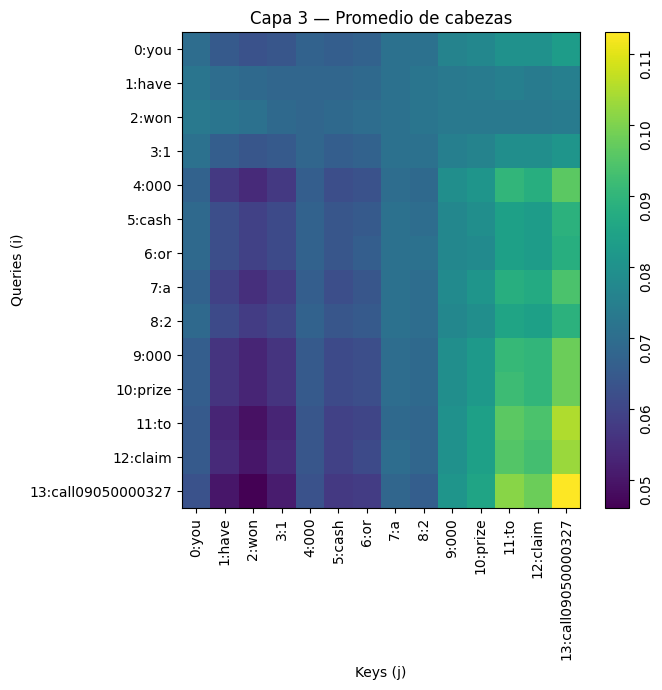

Suma por fila (≈1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


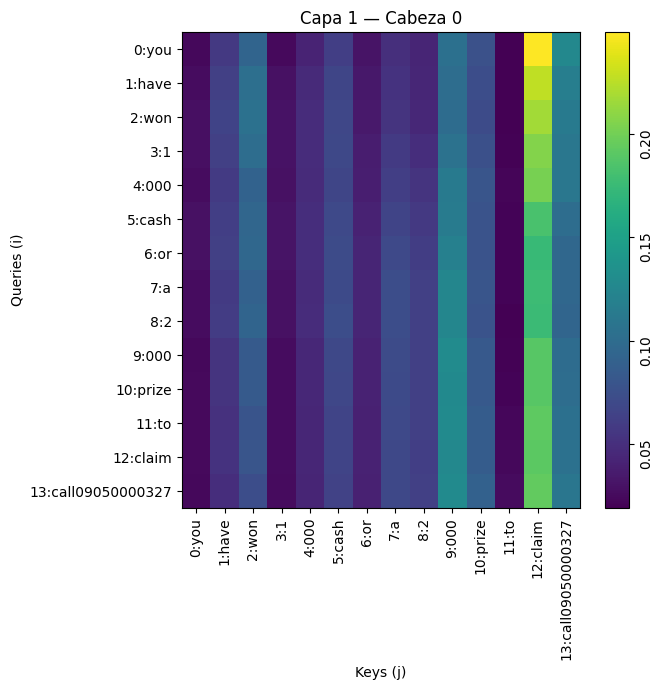

Suma por fila (≈1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[muestra 3] Capa 3 | Consulta 13:call09050000327 | suma fila ≈ 1.000


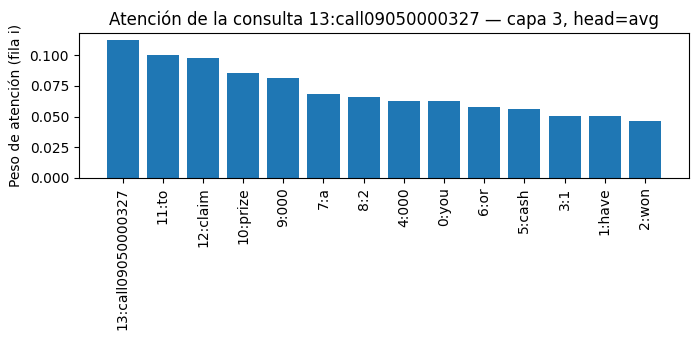

Capa 3 — Relevancia GLOBAL (promedio cabezas y consultas)


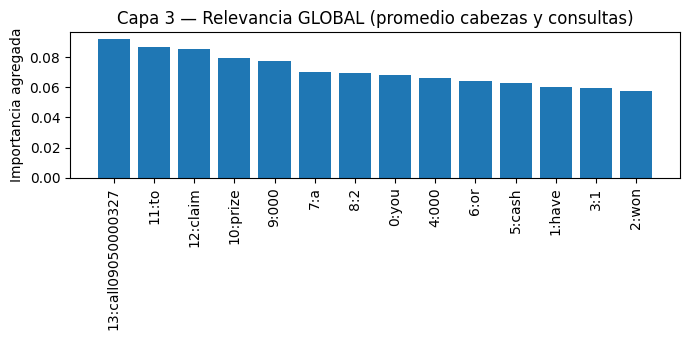

In [18]:
# Heatmap promedio de cabezas en la ÚLTIMA capa
show_attention(sample_index=3, layer_idx=3, head='avg', valid_only=True)

# Heatmap de una cabeza en la PRIMERA capa
show_attention(sample_index=3, layer_idx=1, head=0, valid_only=True)

# Barras: pesos de atención de la consulta 'last' (último token) en la capa 3
bar_scores_for_query(sample_index=3, layer_idx=3, head='avg', query='last', sort=True)

# Relevancia global (promedio de cabezas y consultas) en la capa 3
global_relevance(sample_index=3, layer_idx=3, agg='mean', sort=True, valid_only=True)


##  Tarea: Explorar cabezas de atención y sacar conclusiones

**Objetivo:** desarrollar criterio para interpretar qué aprende cada cabeza y cómo evoluciona a través de las capas.

### Parte A — Exploración por cabeza y por capa
Usa las funciones `show_attention`, `bar_scores_for_query` y `global_relevance` que ya tienes para analizar **cada cabeza** en **cada capa**. Para al menos **5 mensajes** del set de prueba:

1. **Mapa de calor por cabeza**  
   - Capa 1 y Capa 3 (p. ej., `head=0..num_heads-1`), con `valid_only=True`.  
   - ¿Las cabezas enfocan puntuación, números, URLs, saludos, mayúsculas, o palabras clave de spam?

2. **Barras por consulta**  
   - Elige la **última consulta** (`query='last'`) y una intermedia; compara qué tokens reciben más peso.  
   - ¿Cambia el patrón entre Capa 1 y Capa 3?

3. **Relevancia global por token**  
   - Compara `agg='mean'` vs `agg='sum'` en `global_relevance`.  
   - ¿Qué tokens resultan ser “hubs” (reciben atención de muchas consultas)?

4. **Comparativo ham vs. spam**  
   - Elige una muestra ham y una spam.  
   - Describe diferencias de patrones (p. ej., spam: números, ofertas, call-to-action, links).

**Entregable (breve):**
- 4–6 capturas (heatmaps y/o barras) con pie de figura claro.  
- Un texto de ~10–15 líneas con **tus conclusiones** por cabeza y por capa.

---

### Parte B — Relevancia promedio sobre **todas** las capas y **todas** las cabezas
Implementa/usa una función que:
- agregue la atención de **todas las capas** y **todas las cabezas**,  
- agregue también sobre **todas las consultas** (filas),  
- produzca una **importancia final por token (como clave)**.

**Preguntas guía:**
- ¿Qué tokens dominan la relevancia global?  
- ¿Cambian tus conclusiones si usas `mean` vs `sum`?  
- ¿Qué pasa si normalizas por longitud del mensaje (ideas de robustez)?


### Parte A

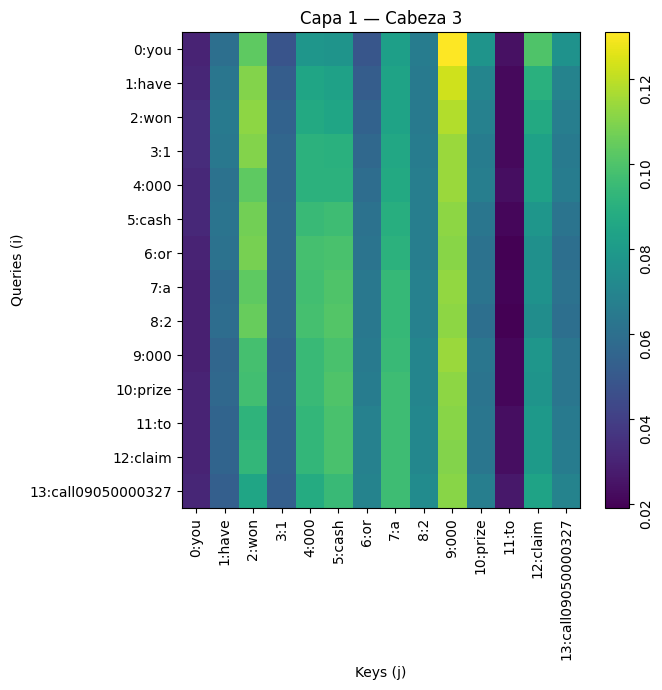

Suma por fila (≈1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


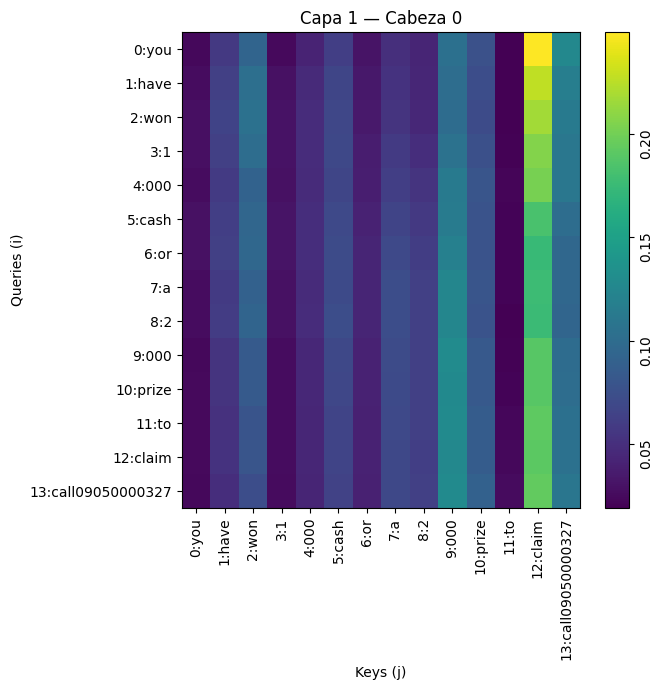

Suma por fila (≈1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [22]:
# Heatmap de las cabezas
show_attention(sample_index=3, layer_idx=1, head=3, valid_only=True)
show_attention(sample_index=3, layer_idx=1, head=0, valid_only=True)

[muestra 3] Capa 1 | Consulta 13:call09050000327 | suma fila ≈ 1.000


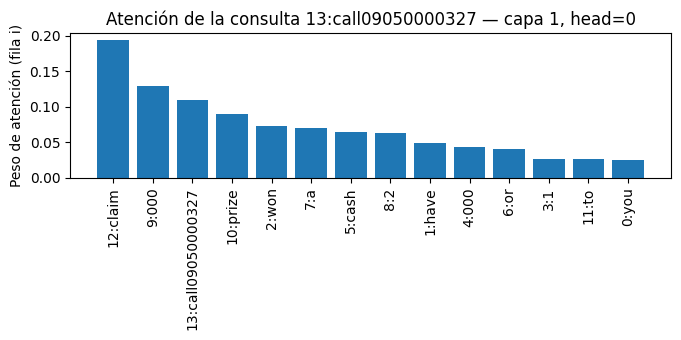

[muestra 3] Capa 1 | Consulta 0:you | suma fila ≈ 1.000


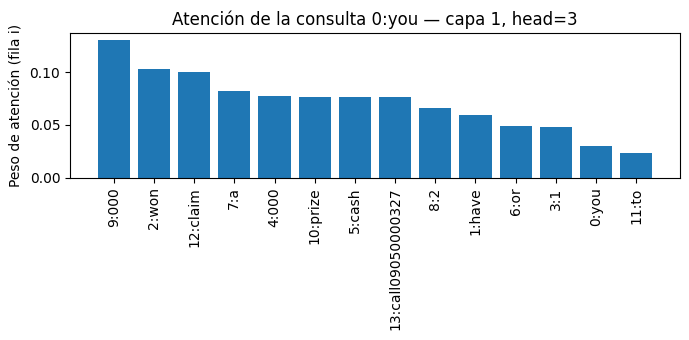

In [33]:
# Barras: pesos de atención de la consulta 'last' (último token) en la capa 3
bar_scores_for_query(sample_index=3, layer_idx=1, head=0, query='last', sort=True)
bar_scores_for_query(sample_index=3, layer_idx=1, head=3, query='0', sort=True)


No hay cambios realmente relevantes entre los tokens de las diferentes heads, lo que si podemos verificar es una diferencia en la distribucion de los tokens, por ejemplo la capa 3 tiene una distribucion un poco mas uniforme lo que implicaria por ejemplo, una palabra como call... sera mas relevante en head=0.

Capa 1 — Relevancia GLOBAL (promedio cabezas y consultas)


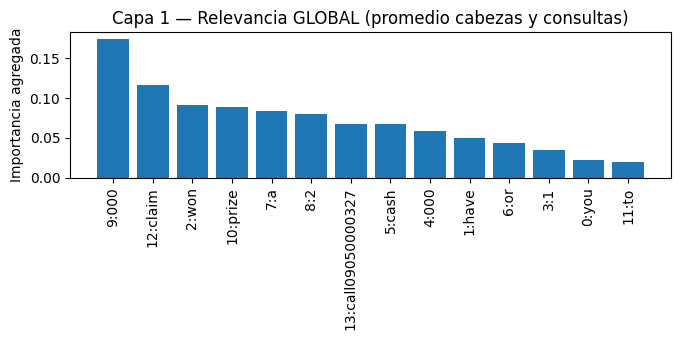

Capa 1 — Relevancia GLOBAL (suma cabezas y consultas)


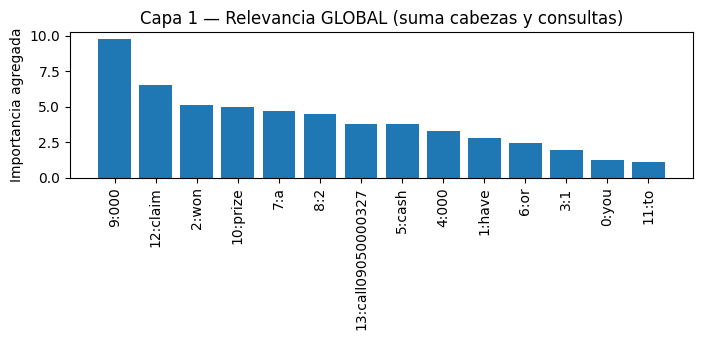

In [32]:
# Relevancia global (promedio de cabezas y consultas) en la capa 3
global_relevance(sample_index=3, layer_idx=1, agg='mean', sort=True, valid_only=True)
global_relevance(sample_index=3, layer_idx=1, agg='sum', sort=True, valid_only=True)

Los tokens que reciben mucha atencion, tanto normalizados como sin normalizar parecen ser similares.

In [31]:
y_test.head()

,label
2825,0
3695,0
3904,0
576,1
2899,0


Capa 1 — Relevancia GLOBAL (promedio cabezas y consultas)


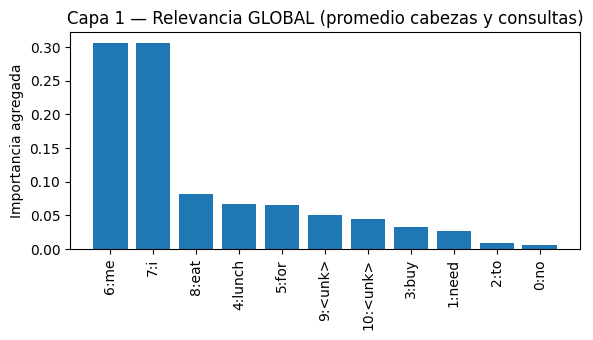

Capa 1 — Relevancia GLOBAL (promedio cabezas y consultas)


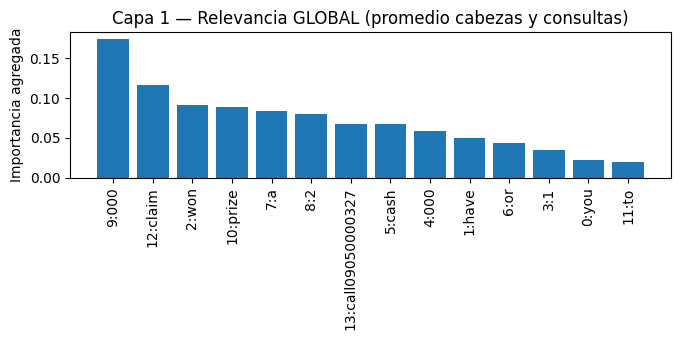

In [35]:
# Relevancia global (promedio de cabezas y consultas) en la capa 3
global_relevance(sample_index=0, layer_idx=1, agg='mean', sort=True, valid_only=True)
global_relevance(sample_index=3, layer_idx=1, agg='mean', sort=True, valid_only=True)

Claramente los correos que tiene spam tiene gran cantidad de numeros, palabras muy llamativas como "claim" o "won", por otro lado los no spam no tienen tanta mencion a numeros.

### Parte B

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

def global_relevance_all_layers(
    sample_index=0,
    layers=[1, 2, 3],
    agg='mean',
    sort=True,
    valid_only=True,
    decimals=3,
    normalize_by_length=False
):
    """
    Agrega atención sobre TODAS las capas, TODAS las cabezas y TODAS las consultas.

    Parámetros:
    -----------
    sample_index : int
        Índice de la muestra en X_test
    layers : list
        Lista de capas a agregar (ej: [1, 2, 3])
    agg : str
        'mean' o 'sum' para agregar sobre capas/cabezas/consultas
    sort : bool
        Si ordenar tokens por relevancia descendente
    valid_only : bool
        Si considerar solo tokens válidos (no padding)
    decimals : int
        Decimales para redondeo
    normalize_by_length : bool
        Si normalizar por la longitud del mensaje

    Retorna:
    --------
    dict con 'tokens', 'weights', 'labels', 'metadata'
    """
    text = X_test.iloc[sample_index]
    pad = _pad_one(text)
    ids_arr = pad[0]

    # Identificar tokens válidos
    valid_idx = np.where(ids_arr != 0)[0]

    if valid_only and valid_idx.size > 0:
        tokens = [index_word.get(int(ids_arr[i]), "<unk>") for i in valid_idx]
        num_tokens = len(valid_idx)
    else:
        tokens = [index_word.get(int(t), "<unk>") if t!=0 else "<pad>" for t in ids_arr]
        valid_idx = np.arange(len(tokens))
        num_tokens = len(tokens)

    # Acumular scores de todas las capas
    accumulated_scores = None
    layer_contributions = {}

    for layer_idx in layers:
        A_full = extractors[layer_idx].predict(pad, verbose=0)[0]  # (heads, T, T)

        if valid_only and valid_idx.size > 0:
            A = A_full[:, valid_idx, :][:, :, valid_idx]  # (h, Tv, Tv)
        else:
            A = A_full

        # Agregar sobre cabezas y consultas (dimensiones 0 y 1)
        # Resultado: vector de tamaño (Tv,) representando importancia de cada KEY
        if agg == 'mean':
            layer_scores = A.mean(axis=(0, 1))  # promedio sobre heads y queries
        else:  # sum
            layer_scores = A.sum(axis=(0, 1))

        layer_contributions[layer_idx] = layer_scores

        if accumulated_scores is None:
            accumulated_scores = layer_scores
        else:
            accumulated_scores += layer_scores

    # Agregación final entre capas
    if agg == 'mean':
        final_weights = accumulated_scores / len(layers)
    else:
        final_weights = accumulated_scores

    # Normalización por longitud (robustez)
    if normalize_by_length:
        final_weights = final_weights / num_tokens

    # Preparar etiquetas
    labels = [f"{i}:{t}" for i, t in enumerate(tokens)]

    # Ordenar si se solicita
    if sort:
        order = np.argsort(-final_weights)
        final_weights = final_weights[order]
        labels = [labels[j] for j in order]
        tokens_sorted = [tokens[j] for j in order]
    else:
        tokens_sorted = tokens

    # Visualización
    title = f"Relevancia GLOBAL — {len(layers)} capas, {agg} (norm_length={normalize_by_length})"
    print(f"\n{'='*60}")
    print(f"Muestra {sample_index}: '{text[:50]}...'")
    print(f"Agregación: {agg} | Normalizado por longitud: {normalize_by_length}")
    print(f"Capas: {layers} | Tokens válidos: {num_tokens}")
    print(f"{'='*60}\n")

    # Gráfico de barras
    plt.figure(figsize=(max(8, len(labels)*0.5), 4))
    bars = plt.bar(range(len(labels)), final_weights, alpha=0.7, edgecolor='black')

    # Colorear las 3 barras más importantes
    if len(bars) >= 3:
        for i in range(min(3, len(bars))):
            bars[i].set_color(['gold', 'silver', 'chocolate'][i])

    plt.xticks(range(len(labels)), labels, rotation=90, fontsize=9)
    plt.ylabel("Importancia agregada", fontsize=11)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Tabla de resultados
    df = pd.DataFrame({
        "Rank": range(1, len(labels)+1),
        "Token": tokens_sorted,
        "Peso": np.round(final_weights, decimals),
        "% del total": np.round(100 * final_weights / final_weights.sum(), 2)
    })

    print("\n📊 Top tokens por relevancia global:")
    display(df.head(10))

    # Estadísticas por capa
    print("\n📈 Contribución por capa:")
    layer_stats = []
    for layer_idx in layers:
        contrib = layer_contributions[layer_idx]
        layer_stats.append({
            'Capa': layer_idx,
            'Mean': np.round(contrib.mean(), decimals),
            'Std': np.round(contrib.std(), decimals),
            'Max': np.round(contrib.max(), decimals),
            'Top token': tokens[np.argmax(contrib)]
        })
    display(pd.DataFrame(layer_stats))

    return {
        'tokens': tokens_sorted,
        'weights': final_weights,
        'labels': labels,
        'layer_contributions': layer_contributions,
        'metadata': {
            'sample_index': sample_index,
            'agg': agg,
            'normalize_by_length': normalize_by_length,
            'num_tokens': num_tokens
        }
    }


def compare_aggregation_methods(sample_index=0, layers=[1, 2, 3], valid_only=True):
    """
    Compara diferentes métodos de agregación (mean vs sum) y normalización.
    """
    print(f"\n{'#'*70}")
    print(f"# COMPARACIÓN DE MÉTODOS DE AGREGACIÓN")
    print(f"{'#'*70}\n")

    configs = [
        ('mean', False, 'Promedio sin normalizar'),
        ('sum', False, 'Suma sin normalizar'),
        ('mean', True, 'Promedio normalizado por longitud'),
        ('sum', True, 'Suma normalizada por longitud')
    ]

    results = {}

    for agg, normalize, desc in configs:
        print(f"\n{'─'*60}")
        print(f"🔍 Método: {desc}")
        print(f"{'─'*60}")

        result = global_relevance_all_layers(
            sample_index=sample_index,
            layers=layers,
            agg=agg,
            sort=True,
            valid_only=valid_only,
            normalize_by_length=normalize
        )

        results[desc] = result

    # Comparar top-3 tokens entre métodos
    print(f"\n{'='*70}")
    print("📋 RESUMEN: Top-3 tokens por método")
    print(f"{'='*70}\n")

    comparison_data = []
    for desc, result in results.items():
        top3 = result['tokens'][:3]
        comparison_data.append({
            'Método': desc,
            'Top-1': top3[0] if len(top3) > 0 else '-',
            'Top-2': top3[1] if len(top3) > 1 else '-',
            'Top-3': top3[2] if len(top3) > 2 else '-'
        })

    display(pd.DataFrame(comparison_data))

    return results


def analyze_layer_evolution(sample_index=0, top_k=5, valid_only=True):
    """
    Analiza cómo evoluciona la relevancia de los top-k tokens a través de las capas.
    """
    text = X_test.iloc[sample_index]
    pad = _pad_one(text)
    ids_arr = pad[0]

    valid_idx = np.where(ids_arr != 0)[0]
    if valid_only and valid_idx.size > 0:
        tokens = [index_word.get(int(ids_arr[i]), "<unk>") for i in valid_idx]
    else:
        tokens = [index_word.get(int(t), "<unk>") if t!=0 else "<pad>" for t in ids_arr]
        valid_idx = np.arange(len(tokens))

    # Calcular relevancia por capa
    layer_data = {}
    for layer_idx in [1, 2, 3]:
        A_full = extractors[layer_idx].predict(pad, verbose=0)[0]
        if valid_only and valid_idx.size > 0:
            A = A_full[:, valid_idx, :][:, :, valid_idx]
        else:
            A = A_full

        layer_data[layer_idx] = A.mean(axis=(0, 1))

    # Encontrar top-k tokens globales
    global_scores = sum(layer_data.values())
    top_indices = np.argsort(-global_scores)[:top_k]

    # Graficar evolución
    plt.figure(figsize=(10, 5))
    for idx in top_indices:
        scores_across_layers = [layer_data[l][idx] for l in [1, 2, 3]]
        plt.plot([1, 2, 3], scores_across_layers, marker='o', linewidth=2,
                label=f"{idx}:{tokens[idx]}")

    plt.xlabel("Capa", fontsize=12)
    plt.ylabel("Relevancia promedio", fontsize=12)
    plt.title(f"Evolución de relevancia: Top-{top_k} tokens", fontsize=13, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks([1, 2, 3])
    plt.tight_layout()
    plt.show()


Muestra 0: 'No need to buy lunch for me.. I eat maggi mee.....'
Agregación: mean | Normalizado por longitud: False
Capas: [1, 2, 3] | Tokens válidos: 11



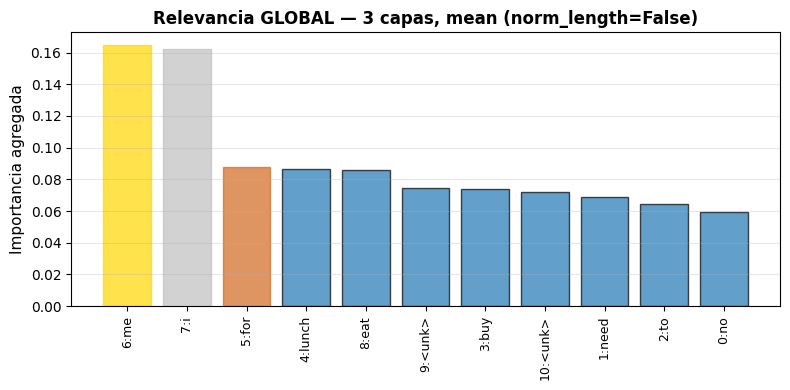


📊 Top tokens por relevancia global:


,Rank,Token,Peso,% del total
0,1,me,0.165,16.459999
1,2,i,0.162,16.200001
2,3,for,0.088,8.810000
3,4,lunch,0.086,8.640000
4,5,eat,0.086,8.610000
5,6,<unk>,0.074,7.440000
6,7,buy,0.074,7.390000
7,8,<unk>,0.072,7.190000
8,9,need,0.069,6.870000
9,10,to,0.065,6.460000



📈 Contribución por capa:


,Capa,Mean,Std,Max,Top token
0,1,0.273,0.106,0.494,me
1,2,0.091,0.011,0.106,for
2,3,0.091,0.006,0.099,<unk>



######################################################################
# COMPARACIÓN DE MÉTODOS DE AGREGACIÓN
######################################################################


────────────────────────────────────────────────────────────
🔍 Método: Promedio sin normalizar
────────────────────────────────────────────────────────────

Muestra 0: 'No need to buy lunch for me.. I eat maggi mee.....'
Agregación: mean | Normalizado por longitud: False
Capas: [1, 2, 3] | Tokens válidos: 11



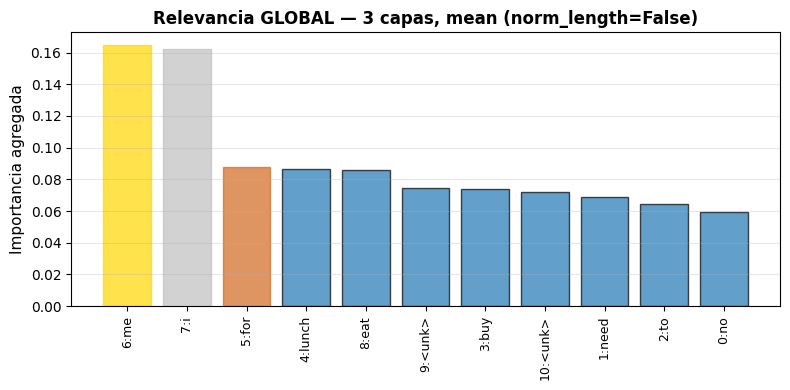


📊 Top tokens por relevancia global:


,Rank,Token,Peso,% del total
0,1,me,0.165,16.459999
1,2,i,0.162,16.200001
2,3,for,0.088,8.810000
3,4,lunch,0.086,8.640000
4,5,eat,0.086,8.610000
5,6,<unk>,0.074,7.440000
6,7,buy,0.074,7.390000
7,8,<unk>,0.072,7.190000
8,9,need,0.069,6.870000
9,10,to,0.065,6.460000



📈 Contribución por capa:


,Capa,Mean,Std,Max,Top token
0,1,0.273,0.106,0.494,me
1,2,0.091,0.011,0.106,for
2,3,0.091,0.006,0.099,<unk>



────────────────────────────────────────────────────────────
🔍 Método: Suma sin normalizar
────────────────────────────────────────────────────────────

Muestra 0: 'No need to buy lunch for me.. I eat maggi mee.....'
Agregación: sum | Normalizado por longitud: False
Capas: [1, 2, 3] | Tokens válidos: 11



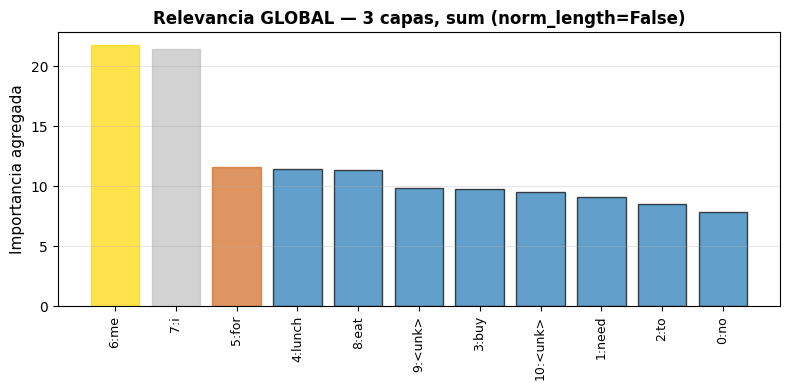


📊 Top tokens por relevancia global:


,Rank,Token,Peso,% del total
0,1,me,21.722000,16.459999
1,2,i,21.389999,16.200001
2,3,for,11.626000,8.810000
3,4,lunch,11.400000,8.640000
4,5,eat,11.369000,8.610000
5,6,<unk>,9.823000,7.440000
6,7,buy,9.752000,7.390000
7,8,<unk>,9.489000,7.190000
8,9,need,9.064000,6.870000
9,10,to,8.525000,6.460000



📈 Contribución por capa:


,Capa,Mean,Std,Max,Top token
0,1,12.0,4.648,21.722,me
1,2,4.0,0.492,4.648,for
2,3,4.0,0.247,4.345,<unk>



────────────────────────────────────────────────────────────
🔍 Método: Promedio normalizado por longitud
────────────────────────────────────────────────────────────

Muestra 0: 'No need to buy lunch for me.. I eat maggi mee.....'
Agregación: mean | Normalizado por longitud: True
Capas: [1, 2, 3] | Tokens válidos: 11



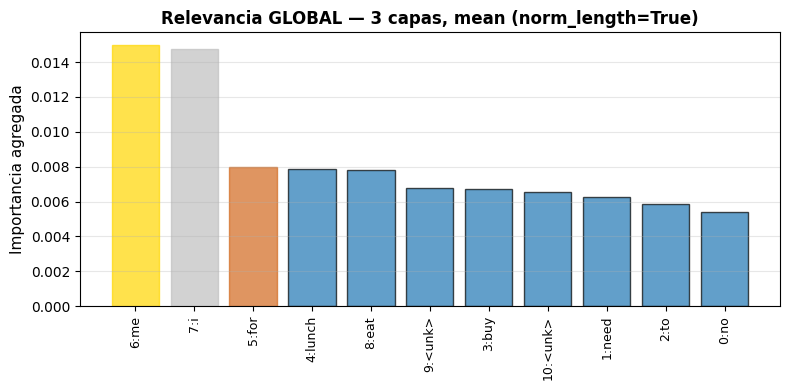


📊 Top tokens por relevancia global:


,Rank,Token,Peso,% del total
0,1,me,0.015,16.459999
1,2,i,0.015,16.200001
2,3,for,0.008,8.810000
3,4,lunch,0.008,8.640000
4,5,eat,0.008,8.610000
5,6,<unk>,0.007,7.440000
6,7,buy,0.007,7.390000
7,8,<unk>,0.007,7.190000
8,9,need,0.006,6.870000
9,10,to,0.006,6.460000



📈 Contribución por capa:


,Capa,Mean,Std,Max,Top token
0,1,0.273,0.106,0.494,me
1,2,0.091,0.011,0.106,for
2,3,0.091,0.006,0.099,<unk>



────────────────────────────────────────────────────────────
🔍 Método: Suma normalizada por longitud
────────────────────────────────────────────────────────────

Muestra 0: 'No need to buy lunch for me.. I eat maggi mee.....'
Agregación: sum | Normalizado por longitud: True
Capas: [1, 2, 3] | Tokens válidos: 11



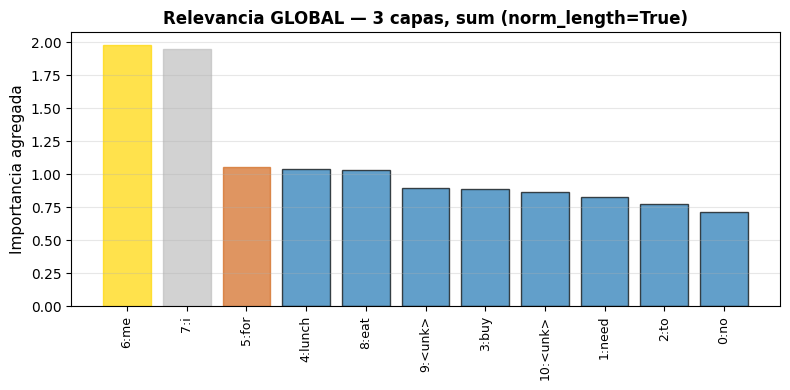


📊 Top tokens por relevancia global:


,Rank,Token,Peso,% del total
0,1,me,1.975,16.459999
1,2,i,1.945,16.200001
2,3,for,1.057,8.810000
3,4,lunch,1.036,8.640000
4,5,eat,1.034,8.610000
5,6,<unk>,0.893,7.440000
6,7,buy,0.887,7.390000
7,8,<unk>,0.863,7.190000
8,9,need,0.824,6.870000
9,10,to,0.775,6.460000



📈 Contribución por capa:


,Capa,Mean,Std,Max,Top token
0,1,12.0,4.648,21.722,me
1,2,4.0,0.492,4.648,for
2,3,4.0,0.247,4.345,<unk>



📋 RESUMEN: Top-3 tokens por método



,Método,Top-1,Top-2,Top-3
0,Promedio sin normalizar,me,i,for
1,Suma sin normalizar,me,i,for
2,Promedio normalizado por longitud,me,i,for
3,Suma normalizada por longitud,me,i,for


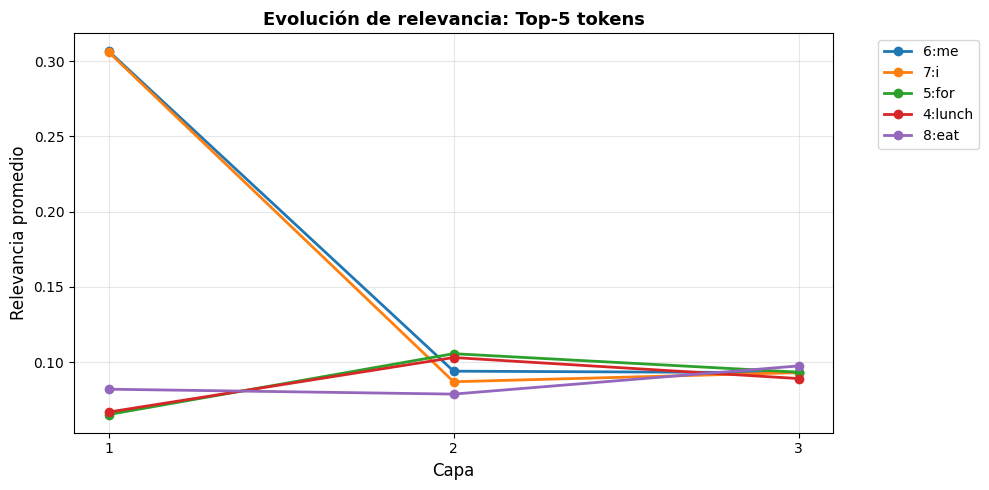

In [39]:


# ============================================================
# EJEMPLO DE USO
# ============================================================
#
# # Análisis básico
result = global_relevance_all_layers(sample_index=0, layers=[1,2,3], agg='mean')
#
# # Comparar métodos
comparison = compare_aggregation_methods(sample_index=0)
#
# # Analizar evolución por capas
analyze_layer_evolution(sample_index=0, top_k=5)

In [40]:
print("Distribución de etiquetas en el dataset:")
print(df['label'].value_counts())

Distribución de etiquetas en el dataset:
label
0    4825
1     747
Name: count, dtype: int64


Claramente tanto la diferencia entre los tokens a nivel global no es especialmente relevante, pues los tokens de correos ham son muchos mas que los de spam, aun asi normalizando con el mean, las primeras capas se puede notar mas la diferencia de relevancia en los tokens.